<a href="https://colab.research.google.com/github/Ni7070/lifelong_learning/blob/master/LL(Experiment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#tensor_set.py 

import os

import torch

from torch.utils.data import Dataset
from tqdm import tqdm


class TensorDataset(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.rows, self.labels = data[:, :-1], data[:, -1]
        self.n = len(self.labels)

    def __getitem__(self, index):
        return self.rows[index], self.labels[index]

    def __len__(self):
        return self.n


def extract_features(image_dataset: Dataset, extractor: torch.nn.Module, out_path: str, device='cpu'):
    print('Extracting features...')
    loader = torch.utils.data.DataLoader(image_dataset, batch_size=256, num_workers=4)
    n = len(image_dataset)
    init = False
    all_data = None

    i = 0
    for inputs, labels in tqdm(loader):
        with torch.no_grad():
            print('in', inputs.shape)
            features = extractor(inputs.to(device)).cpu()
            print('out', features.shape)
            if not init:
                all_data = torch.zeros((n, features.shape[1] + 1))
                init = True

            all_data[i:i + len(features), :-1] = features
            all_data[i:i + len(features), -1] = labels

        i += len(features)
        print(i)

    print(f'Saving to {out_path}')
    os.makedirs(os.path.join(*out_path.split('/')[:-1]), exist_ok=True)
    torch.save(all_data, out_path)

In [ ]:
#learners/model/resnext.py 

from __future__ import division

import torch

""" 
Creates a ResNeXt Model as defined in:
Xie, S., Girshick, R., Dollar, P., Tu, Z., & He, K. (2016). 
Aggregated residual transformations for deep neural networks. 
arXiv preprint arXiv:1611.05431.
import from https://github.com/prlz77/ResNeXt.pytorch/blob/master/models/model.py
"""
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

__all__ = ['resnext']


class ResNeXtBottleneck(nn.Module):
    """
    RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
    """
    def __init__(self, in_channels, out_channels, stride, cardinality, widen_factor):
        """ Constructor
        Args:
            in_channels: input channel dimensionality
            out_channels: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            cardinality: num of convolution groups.
            widen_factor: factor to reduce the input dimensionality before convolution.
        """
        super(ResNeXtBottleneck, self).__init__()
        D = cardinality * out_channels // widen_factor
        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('shortcut_conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False))
            self.shortcut.add_module('shortcut_bn', nn.BatchNorm2d(out_channels))

    def forward(self, x):
        bottleneck = self.conv_reduce.forward(x)
        bottleneck = F.relu(self.bn_reduce.forward(bottleneck), inplace=True)
        bottleneck = self.conv_conv.forward(bottleneck)
        bottleneck = F.relu(self.bn.forward(bottleneck), inplace=True)
        bottleneck = self.conv_expand.forward(bottleneck)
        bottleneck = self.bn_expand.forward(bottleneck)
        residual = self.shortcut.forward(x)
        return F.relu(residual + bottleneck, inplace=True)


class CifarResNeXt(nn.Module):
    """
    ResNext optimized for the Cifar dataset, as specified in
    https://arxiv.org/pdf/1611.05431.pdf
    """
    def __init__(self, cardinality, depth, num_classes, widen_factor=4, dropRate=0):
        """ Constructor
        Args:
            cardinality: number of convolution groups.
            depth: number of layers.
            num_classes: number of classes
            widen_factor: factor to adjust the channel dimensionality
        """
        super(CifarResNeXt, self).__init__()
        self.cardinality = cardinality
        self.depth = depth
        self.block_depth = (self.depth - 2) // 9
        self.widen_factor = widen_factor
        self.num_classes = num_classes
        self.output_size = 64
        self.stages = [64, 64 * self.widen_factor, 128 * self.widen_factor, 256 * self.widen_factor]

        self.conv_1_3x3 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.stage_1 = self.block('stage_1', self.stages[0], self.stages[1], 1)
        self.stage_2 = self.block('stage_2', self.stages[1], self.stages[2], 2)
        self.stage_3 = self.block('stage_3', self.stages[2], self.stages[3], 2)
        self.classifier = nn.Linear(1024, num_classes)
        init.kaiming_normal(self.classifier.weight)

        for key in self.state_dict():
            if key.split('.')[-1] == 'weight':
                if 'conv' in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if 'bn' in key:
                    self.state_dict()[key][...] = 1
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0

    def block(self, name, in_channels, out_channels, pool_stride=2):
        """ Stack n bottleneck modules where n is inferred from the depth of the network.
        Args:
            name: string name of the current block.
            in_channels: number of input channels
            out_channels: number of output channels
            pool_stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.
        Returns: a Module consisting of n sequential bottlenecks.
        """
        block = nn.Sequential()
        for bottleneck in range(self.block_depth):
            name_ = '%s_bottleneck_%d' % (name, bottleneck)
            if bottleneck == 0:
                block.add_module(name_, ResNeXtBottleneck(in_channels, out_channels, pool_stride, self.cardinality,
                                                          self.widen_factor))
            else:
                block.add_module(name_,
                                 ResNeXtBottleneck(out_channels, out_channels, 1, self.cardinality, self.widen_factor))
        return block

    def forward(self, x):
        x = self.conv_1_3x3.forward(x)
        x = F.relu(self.bn_1.forward(x), inplace=True)
        x = self.stage_1.forward(x)
        x = self.stage_2.forward(x)
        x = self.stage_3.forward(x)
        x = F.avg_pool2d(x, 8, 1)
        x = x.view(-1, 1, 1024)

        # todo: remove
        x = F.avg_pool1d(x, 2)
        x = x.view(-1, 512)

        return x
        #return self.classifier(x)


def create_cifar_resnext(model_path: str):
    checkpoint = torch.load(model_path)
    state_dict = checkpoint['state_dict']

    # new_state_dict = OrderedDict()
    # for k, v in state_dict.items():
    #     if 'module' not in k:
    #         k = 'module.'+k
    #     else:
    #         k = k.replace('features.module.', 'module.features.')
    #     new_state_dict[k] = v

    net = CifarResNeXt(depth=29, cardinality=8, num_classes=100, widen_factor=4)
    net = torch.nn.DataParallel(net)
    net.load_state_dict(state_dict)

    return net

In [ ]:
#Data_Utils
import collections
import os
import zipfile
from typing import Optional, Callable, Dict
import torch
from typing import Sequence
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
from torch.utils.data.dataset import T_co


class IndexDataset(Dataset):

    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset.__getitem__(index)
        return data, target, index

    def __len__(self):
        return self.dataset.__len__()


class ClassSubset(Subset):

    def __init__(self, dataset: Dataset[T_co], indices: Sequence[int], classes: Sequence[int]) -> None:
        super().__init__(dataset, indices)
        self.cls_map = {c: i for i, c in enumerate(classes)}

    def __getitem__(self, idx):
        img, target = self.dataset[self.indices[idx]]
        return img, self.cls_map[target]


class DataUtils:

    @staticmethod
    def create_dataset_subset(dataset: Dataset, classes: list, indices_path: str):
        if os.path.exists(indices_path):
            print(f'Loading indices from {indices_path}')
            return ClassSubset(dataset, torch.load(indices_path), classes)

        indices_per_class = DataUtils.get_class_indices(IndexDataset(dataset))

        indices = []
        for c in classes:
            indices.extend(indices_per_class[c])

        print(f'Writing indices to {indices_path}')
        torch.save(indices, indices_path)

        return ClassSubset(dataset, indices, classes)

    @staticmethod
    def create_dataset(root: str, dir_name: str, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None,
                       download: bool = False, download_func: Optional[Callable] = None, zip_file: str = None, post_func: Optional[Callable] = None):
        input_folder = os.path.join(root, dir_name)

        if not os.path.exists(input_folder):
            if download and download_func is not None:
                print('Downloading the dataset')
                download_func()

                if os.path.exists(f'{root}/{zip_file}'):
                    print(f'Extracting from {zip_file}')

                    with zipfile.ZipFile(f'{root}/{zip_file}', 'r') as zip_ref:
                        zip_ref.extractall(root)
            else:
                raise RuntimeError('Dataset not found. You can use download=True to download it')

        if post_func is not None:
            post_func(input_folder)

        return ImageFolder(input_folder, transform, target_transform)

    @staticmethod
    def get_class_indices(dataset: IndexDataset) -> Dict[int, list]:
        class_indices = collections.defaultdict(list)

        for inputs, labels, indices in DataLoader(dataset, batch_size=1024, num_workers=4):
            for label, idx in zip(labels.tolist(), indices.tolist()):
                class_indices[label].append(idx)

        return class_indices

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=029918dc0dc74dbbb0a9e1bc063dbef3f379a01446a37dd3eb1b18212b6726b8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_cifar_resnext29_pth_tar = '/content/drive/MyDrive/pth files/cifar_resnext29.pth.tar'
svhn_train_save_path1 = '/content/drive/MyDrive/pth files/svhn10-2-train.pt'
svhn_test_save_path1 = '/content/drive/MyDrive/pth files/svhn10-2-test.pt'
svhn_train_save_path2 = '/content/drive/MyDrive/pth files/svhn10-train.pt'
svhn_test_save_path2 = '/content/drive/MyDrive/pth files/svhn10-test.pt'

In [ ]:
#data.data_collection

import torch
import wget

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image

# from data.cifar100_coarse import CIFAR100Coarse
# from data.data_utils import DataUtils
# from data.post_funcs import imagenet200_val_post
# from data.tensor_set import TensorDataset

pytorch_data_root = './pytorch_data'
arff_data_root = './arff_data'



data_creators = {
    # 'MNIST-TRAIN': lambda: datasets.MNIST(pytorch_data_root, train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])),
    # 'MNIST-TEST': lambda: datasets.MNIST(pytorch_data_root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
    # 'MNIST-TRAIN-FLAT': lambda: datasets.MNIST(pytorch_data_root, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])),
    # 'MNIST-TEST-FLAT': lambda: datasets.MNIST(pytorch_data_root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])),
    # 'MNIST-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/mnist10-train.pt'),
    # 'MNIST-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/mnist10-test.pt'),
    # 'FASHION-TRAIN': lambda: datasets.FashionMNIST(pytorch_data_root, train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])),
    # 'FASHION-TEST': lambda: datasets.FashionMNIST(pytorch_data_root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
    # 'FASHION-TRAIN-FLAT': lambda: datasets.FashionMNIST(pytorch_data_root, train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])),
    # 'FASHION-TEST-FLAT': lambda: datasets.FashionMNIST(pytorch_data_root, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])),
    # 'FASHION-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/fashion10-train.pt'),
    # 'FASHION-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/fashion10-test.pt'),
    'SVHN-TRAIN': lambda: datasets.SVHN(pytorch_data_root, split='train', transform=transforms.Compose([transforms.ToTensor()]), download=True),
    'SVHN-TEST': lambda: datasets.SVHN(pytorch_data_root, split='test', transform=transforms.Compose([transforms.ToTensor()]), download=True),
    'SVHN-TRAIN-TENSOR': lambda: TensorDataset(svhn_train_save_path1),
    'SVHN-TEST-TENSOR': lambda: TensorDataset(svhn_test_save_path1),
    # 'SVHN-TRAIN-TENSOR': lambda: TensorDataset(svhn_train_save_path2),
    # 'SVHN-TEST-TENSOR': lambda: TensorDataset(svhn_train_save_path2),
    
    # 'CIFAR10-TRAIN': lambda: datasets.CIFAR10(pytorch_data_root, True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()]), download=True),
    # 'CIFAR10-TEST': lambda: datasets.CIFAR10(pytorch_data_root, False, transform=transforms.Compose([transforms.ToTensor()]), download=True),
    # 'CIFAR10-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/cifar10-train.pt'),
    # 'CIFAR10-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/cifar10-test.pt'),
    # 'CIFAR100-TRAIN': lambda: datasets.CIFAR100(pytorch_data_root, True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()]), download=True),
    # 'CIFAR100-TEST': lambda: datasets.CIFAR100(pytorch_data_root, False, transform=transforms.Compose([transforms.ToTensor()]), download=True),
    # 'CIFAR20C-TRAIN': lambda: CIFAR100Coarse(pytorch_data_root, train=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()]), download=True),
    # 'CIFAR20C-TEST': lambda: CIFAR100Coarse(pytorch_data_root, train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True),
    # 'CIFAR20C-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/cifar20c-train.pt'),
    # 'CIFAR20C-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/cifar20c-test.pt'),
    # 'IMAGENET200-TRAIN': lambda: DataUtils.create_dataset(pytorch_data_root, 'tiny-imagenet-200/train',
    #                                                       transform=transforms.Compose([transforms.Resize((224, 224), interpolation=Image.NEAREST), transforms.ToTensor()]),
    #                                             download=True, download_func=lambda: wget.download('http://cs231n.stanford.edu/tiny-imagenet-200.zip', pytorch_data_root),
    #                                             zip_file='tiny-imagenet-200.zip',),
    # 'IMAGENET200-TEST': lambda: DataUtils.create_dataset(pytorch_data_root, 'tiny-imagenet-200/val',
    #                                                      transform=transforms.Compose([transforms.Resize((224, 224), interpolation=Image.NEAREST), transforms.ToTensor()]),
    #                                            download=True, download_func=lambda: wget.download('http://cs231n.stanford.edu/tiny-imagenet-200.zip', pytorch_data_root),
    #                                            zip_file='tiny-imagenet-200.zip', post_func=imagenet200_val_post),
    # 'IMAGENET10-TRAIN': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TRAIN'), [0, 22, 25, 68, 117, 145, 153, 176, 188, 198], f'{pytorch_data_root}/imagenet10-train-indices.pt'),
    # 'IMAGENET10-TEST': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TEST'), [0, 22, 25, 68, 117, 145, 153, 176, 188, 198], f'{pytorch_data_root}/imagenet10-test-indices.pt'),
    # 'IMAGENET10-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet10-train.pt'),
    # 'IMAGENET10-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet10-test.pt'),
    # 'IMAGENET20A-TRAIN': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TRAIN'), [i * 10 - 1 for i in range(1, 21)], f'{pytorch_data_root}/imagenet20a-train-indices.pt'),
    # 'IMAGENET20A-TEST': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TEST'), [i * 10 - 1 for i in range(1, 21)], f'{pytorch_data_root}/imagenet20a-test-indices.pt'),
    # 'IMAGENET20A-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet20a-train.pt'),
    # 'IMAGENET20A-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet20a-test.pt'),
    # 'IMAGENET20B-TRAIN': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TRAIN'), [i * 10 - 5 for i in range(1, 21)], f'{pytorch_data_root}/imagenet20b-train-indices.pt'),
    # 'IMAGENET20B-TEST': lambda: DataUtils.create_dataset_subset(get('IMAGENET200-TEST'), [i * 10 - 5 for i in range(1, 21)], f'{pytorch_data_root}/imagenet20b-test-indices.pt'),
    # 'IMAGENET20B-TRAIN-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet20b-train.pt'),
    # 'IMAGENET20B-TEST-TENSOR': lambda: TensorDataset(f'{pytorch_data_root}/extracted/imagenet20b-test.pt'),
    # 'CELEB-TRAIN': lambda: datasets.CelebA(pytorch_data_root, split='train', target_type='identity', transform=transforms.Compose([transforms.ToTensor()]), download=True),
    # 'CELEB-TEST': lambda: datasets.CelebA(pytorch_data_root, split='test', target_type='identity', transform=transforms.Compose([transforms.ToTensor()]), download=True)

    # TODO:
    # CORE50: https://vlomonaco.github.io/core50/index.html#dataset
    # IMAGENET1000 (64): https://patrykchrabaszcz.github.io/Imagenet32/

    # A) MNIST, FASHION, SVHN, CIFAR10, IMG10
    # B) CORE50, CIFAR100, IMG200
    # C) CELEB, IMG1000
}

class data_collection():
  def get(name: str):
      return data_creators[name]()

In [ ]:
import torch
import torchvision
from torchsummary import summary

# from data.tensor_set import extract_features
# from learners.models.resnext import create_cifar_resnext
# import data.data_collection as data_col


def extract(last):
    print('Running')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # cifar_resnext29.pth.tar -> https://github.com/bearpaw/pytorch-classification/blob/master/models/cifar/resnext.py

    extractor = create_cifar_resnext(path_cifar_resnext29_pth_tar)
    extractor.classifier = torch.nn.Identity()
    extractor.eval().to(device)
    summary(extractor.to(device), (3, 32, 32))
    dataset = data_collection.get('SVHN-TRAIN')
    extract_features(dataset, extractor, svhn_train_save_path1, device=device)
    dataset = data_collection.get('SVHN-TEST')
    extract_features(dataset, extractor, svhn_test_save_path1, device=device)

    # extractor = create_cifar_resnext(path_cifar_resnext29_pth_tar)
    # extractor.classifier = torch.nn.Identity()
    # extractor.eval().to(device)
    # summary(extractor.to(device), (3, 32, 32))
    # dataset = data_collection.get('CIFAR20C-TRAIN')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/cifar20c-train.pt', device=device)
    # dataset = data_collection.get('CIFAR20C-TEST')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/cifar20c-test.pt', device=device)

    # extractor = torchvision.models.resnet18(pretrained=True)
    # fc1 = extractor.fc
    # extractor.fc = torch.nn.Sequential(fc1, torch.nn.Linear(1000, 256), torch.nn.ReLU(), torch.nn.Linear(256, 20))
    # extractor.load_state_dict(torch.load('pytorch_models/imgnet20a-2f.pth'))
    # if not last: extractor.fc = torch.nn.Identity()
    # extractor.eval().to(device)
    # dataset = data_collection.get('IMAGENET20A-TRAIN')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/imagenet20a-train.pt', device=device)
    # dataset = data_collection.get('IMAGENET20A-TEST')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/imagenet20a-test.pt', device=device)

    # extractor = torchvision.models.resnet18(pretrained=True)
    # fc1 = extractor.fc
    # extractor.fc = torch.nn.Sequential(fc1, torch.nn.Linear(1000, 256), torch.nn.ReLU(), torch.nn.Linear(256, 20))
    # extractor.load_state_dict(torch.load('pytorch_models/imgnet20b-2f.pth'))
    # if not last: extractor.fc = torch.nn.Identity()
    # extractor.eval().to(device)
    # dataset = data_collection.get('IMAGENET20B-TRAIN')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/imagenet20b-train.pt', device=device)
    # dataset = data_collection.get('IMAGENET20B-TEST')
    # extract_features(dataset, extractor, f'pytorch_data/extracted/imagenet20b-test.pt', device=device)

In [ ]:
extract(True)

Running


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 32, 32]          16,384
       BatchNorm2d-2          [-1, 256, 32, 32]             512
 ResNeXtBottleneck-3          [-1, 256, 32, 32]               0
 ResNeXtBottleneck-4          [-1, 256, 32, 32]               0
 ResNeXtBottleneck-5          [-1, 256, 32, 32]               0
            Conv2d-6          [-1, 512, 16, 16]         131,072
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
 ResNeXtBottleneck-8          [-1, 512, 16, 16]               0
 ResNeXtBottleneck-9          [-1, 512, 16, 16]               0
ResNeXtBottleneck-10          [-1, 512, 16, 16]               0
           Conv2d-11           [-1, 1024, 8, 8]         524,288
      BatchNorm2d-12           [-1, 1024, 8, 8]           2,048
ResNeXtBottleneck-13           [-1, 1024, 8, 8]               0
ResNeXtBottleneck-14           [-1, 102

  0%|          | 0/182040794 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Extracting features...


  0%|          | 0/287 [00:00<?, ?it/s]

in torch.Size([256, 3, 32, 32])


  0%|          | 1/287 [00:01<04:57,  1.04s/it]

out torch.Size([256, 512])
256
in torch.Size([256, 3, 32, 32])


  1%|          | 2/287 [00:01<03:50,  1.24it/s]

out torch.Size([256, 512])
512
in torch.Size([256, 3, 32, 32])


  1%|          | 3/287 [00:02<03:32,  1.34it/s]

out torch.Size([256, 512])
768
in torch.Size([256, 3, 32, 32])


  1%|▏         | 4/287 [00:03<03:20,  1.41it/s]

out torch.Size([256, 512])
1024
in torch.Size([256, 3, 32, 32])


  2%|▏         | 5/287 [00:03<03:15,  1.45it/s]

out torch.Size([256, 512])
1280
in torch.Size([256, 3, 32, 32])


  2%|▏         | 6/287 [00:04<03:11,  1.47it/s]

out torch.Size([256, 512])
1536
in torch.Size([256, 3, 32, 32])


  2%|▏         | 7/287 [00:05<03:09,  1.48it/s]

out torch.Size([256, 512])
1792
in torch.Size([256, 3, 32, 32])


  3%|▎         | 8/287 [00:05<03:06,  1.50it/s]

out torch.Size([256, 512])
2048
in torch.Size([256, 3, 32, 32])


  3%|▎         | 9/287 [00:06<03:05,  1.50it/s]

out torch.Size([256, 512])
2304
in torch.Size([256, 3, 32, 32])


  3%|▎         | 10/287 [00:06<03:04,  1.50it/s]

out torch.Size([256, 512])
2560
in torch.Size([256, 3, 32, 32])


  4%|▍         | 11/287 [00:07<03:04,  1.50it/s]

out torch.Size([256, 512])
2816
in torch.Size([256, 3, 32, 32])


  4%|▍         | 12/287 [00:08<03:03,  1.50it/s]

out torch.Size([256, 512])
3072
in torch.Size([256, 3, 32, 32])


  5%|▍         | 13/287 [00:08<03:02,  1.50it/s]

out torch.Size([256, 512])
3328
in torch.Size([256, 3, 32, 32])


  5%|▍         | 14/287 [00:09<03:01,  1.50it/s]

out torch.Size([256, 512])
3584
in torch.Size([256, 3, 32, 32])


  5%|▌         | 15/287 [00:10<03:01,  1.50it/s]

out torch.Size([256, 512])
3840
in torch.Size([256, 3, 32, 32])


  6%|▌         | 16/287 [00:10<03:01,  1.49it/s]

out torch.Size([256, 512])
4096
in torch.Size([256, 3, 32, 32])


  6%|▌         | 17/287 [00:11<03:00,  1.49it/s]

out torch.Size([256, 512])
4352
in torch.Size([256, 3, 32, 32])


  6%|▋         | 18/287 [00:12<03:00,  1.49it/s]

out torch.Size([256, 512])
4608
in torch.Size([256, 3, 32, 32])


  7%|▋         | 19/287 [00:13<02:59,  1.49it/s]

out torch.Size([256, 512])
4864
in torch.Size([256, 3, 32, 32])


  7%|▋         | 20/287 [00:13<02:59,  1.49it/s]

out torch.Size([256, 512])
5120
in torch.Size([256, 3, 32, 32])


  7%|▋         | 21/287 [00:14<02:58,  1.49it/s]

out torch.Size([256, 512])
5376
in torch.Size([256, 3, 32, 32])


  8%|▊         | 22/287 [00:15<02:57,  1.49it/s]

out torch.Size([256, 512])
5632
in torch.Size([256, 3, 32, 32])


  8%|▊         | 23/287 [00:15<02:57,  1.49it/s]

out torch.Size([256, 512])
5888
in torch.Size([256, 3, 32, 32])


  8%|▊         | 24/287 [00:16<02:56,  1.49it/s]

out torch.Size([256, 512])
6144
in torch.Size([256, 3, 32, 32])


  9%|▊         | 25/287 [00:17<02:55,  1.49it/s]

out torch.Size([256, 512])
6400
in torch.Size([256, 3, 32, 32])


  9%|▉         | 26/287 [00:17<02:55,  1.49it/s]

out torch.Size([256, 512])
6656
in torch.Size([256, 3, 32, 32])


  9%|▉         | 27/287 [00:18<02:54,  1.49it/s]

out torch.Size([256, 512])
6912
in torch.Size([256, 3, 32, 32])


 10%|▉         | 28/287 [00:19<02:53,  1.49it/s]

out torch.Size([256, 512])
7168
in torch.Size([256, 3, 32, 32])


 10%|█         | 29/287 [00:19<02:52,  1.49it/s]

out torch.Size([256, 512])
7424
in torch.Size([256, 3, 32, 32])


 10%|█         | 30/287 [00:20<02:52,  1.49it/s]

out torch.Size([256, 512])
7680
in torch.Size([256, 3, 32, 32])


 11%|█         | 31/287 [00:21<02:51,  1.49it/s]

out torch.Size([256, 512])
7936
in torch.Size([256, 3, 32, 32])


 11%|█         | 32/287 [00:21<02:51,  1.49it/s]

out torch.Size([256, 512])
8192
in torch.Size([256, 3, 32, 32])


 11%|█▏        | 33/287 [00:22<02:50,  1.49it/s]

out torch.Size([256, 512])
8448
in torch.Size([256, 3, 32, 32])


 12%|█▏        | 34/287 [00:23<02:49,  1.49it/s]

out torch.Size([256, 512])
8704
in torch.Size([256, 3, 32, 32])


 12%|█▏        | 35/287 [00:23<02:49,  1.49it/s]

out torch.Size([256, 512])
8960
in torch.Size([256, 3, 32, 32])


 13%|█▎        | 36/287 [00:24<02:48,  1.49it/s]

out torch.Size([256, 512])
9216
in torch.Size([256, 3, 32, 32])


 13%|█▎        | 37/287 [00:25<02:47,  1.49it/s]

out torch.Size([256, 512])
9472
in torch.Size([256, 3, 32, 32])


 13%|█▎        | 38/287 [00:25<02:47,  1.49it/s]

out torch.Size([256, 512])
9728
in torch.Size([256, 3, 32, 32])


 14%|█▎        | 39/287 [00:26<02:46,  1.49it/s]

out torch.Size([256, 512])
9984
in torch.Size([256, 3, 32, 32])


 14%|█▍        | 40/287 [00:27<02:46,  1.49it/s]

out torch.Size([256, 512])
10240
in torch.Size([256, 3, 32, 32])


 14%|█▍        | 41/287 [00:27<02:46,  1.48it/s]

out torch.Size([256, 512])
10496
in torch.Size([256, 3, 32, 32])


 15%|█▍        | 42/287 [00:28<02:45,  1.48it/s]

out torch.Size([256, 512])
10752
in torch.Size([256, 3, 32, 32])


 15%|█▍        | 43/287 [00:29<02:44,  1.48it/s]

out torch.Size([256, 512])
11008
in torch.Size([256, 3, 32, 32])


 15%|█▌        | 44/287 [00:29<02:45,  1.47it/s]

out torch.Size([256, 512])
11264
in torch.Size([256, 3, 32, 32])


 16%|█▌        | 45/287 [00:30<02:44,  1.47it/s]

out torch.Size([256, 512])
11520
in torch.Size([256, 3, 32, 32])


 16%|█▌        | 46/287 [00:31<02:44,  1.47it/s]

out torch.Size([256, 512])
11776
in torch.Size([256, 3, 32, 32])


 16%|█▋        | 47/287 [00:31<02:44,  1.46it/s]

out torch.Size([256, 512])
12032
in torch.Size([256, 3, 32, 32])


 17%|█▋        | 48/287 [00:32<02:44,  1.45it/s]

out torch.Size([256, 512])
12288
in torch.Size([256, 3, 32, 32])


 17%|█▋        | 49/287 [00:33<02:43,  1.46it/s]

out torch.Size([256, 512])
12544
in torch.Size([256, 3, 32, 32])


 17%|█▋        | 50/287 [00:33<02:42,  1.46it/s]

out torch.Size([256, 512])
12800
in torch.Size([256, 3, 32, 32])


 18%|█▊        | 51/287 [00:34<02:42,  1.45it/s]

out torch.Size([256, 512])
13056
in torch.Size([256, 3, 32, 32])


 18%|█▊        | 52/287 [00:35<02:41,  1.45it/s]

out torch.Size([256, 512])
13312
in torch.Size([256, 3, 32, 32])


 18%|█▊        | 53/287 [00:36<02:41,  1.45it/s]

out torch.Size([256, 512])
13568
in torch.Size([256, 3, 32, 32])


 19%|█▉        | 54/287 [00:36<02:41,  1.45it/s]

out torch.Size([256, 512])
13824
in torch.Size([256, 3, 32, 32])


 19%|█▉        | 55/287 [00:37<02:40,  1.45it/s]

out torch.Size([256, 512])
14080
in torch.Size([256, 3, 32, 32])


 20%|█▉        | 56/287 [00:38<02:40,  1.44it/s]

out torch.Size([256, 512])
14336
in torch.Size([256, 3, 32, 32])


 20%|█▉        | 57/287 [00:38<02:38,  1.45it/s]

out torch.Size([256, 512])
14592
in torch.Size([256, 3, 32, 32])


 20%|██        | 58/287 [00:39<02:38,  1.45it/s]

out torch.Size([256, 512])
14848
in torch.Size([256, 3, 32, 32])


 21%|██        | 59/287 [00:40<02:37,  1.45it/s]

out torch.Size([256, 512])
15104
in torch.Size([256, 3, 32, 32])


 21%|██        | 60/287 [00:40<02:36,  1.45it/s]

out torch.Size([256, 512])
15360
in torch.Size([256, 3, 32, 32])


 21%|██▏       | 61/287 [00:41<02:37,  1.44it/s]

out torch.Size([256, 512])
15616
in torch.Size([256, 3, 32, 32])


 22%|██▏       | 62/287 [00:42<02:36,  1.44it/s]

out torch.Size([256, 512])
15872
in torch.Size([256, 3, 32, 32])


 22%|██▏       | 63/287 [00:42<02:36,  1.43it/s]

out torch.Size([256, 512])
16128
in torch.Size([256, 3, 32, 32])


 22%|██▏       | 64/287 [00:43<02:35,  1.43it/s]

out torch.Size([256, 512])
16384
in torch.Size([256, 3, 32, 32])


 23%|██▎       | 65/287 [00:44<02:35,  1.43it/s]

out torch.Size([256, 512])
16640
in torch.Size([256, 3, 32, 32])


 23%|██▎       | 66/287 [00:45<02:35,  1.42it/s]

out torch.Size([256, 512])
16896
in torch.Size([256, 3, 32, 32])


 23%|██▎       | 67/287 [00:45<02:35,  1.42it/s]

out torch.Size([256, 512])
17152
in torch.Size([256, 3, 32, 32])


 24%|██▎       | 68/287 [00:46<02:34,  1.41it/s]

out torch.Size([256, 512])
17408
in torch.Size([256, 3, 32, 32])


 24%|██▍       | 69/287 [00:47<02:34,  1.41it/s]

out torch.Size([256, 512])
17664
in torch.Size([256, 3, 32, 32])


 24%|██▍       | 70/287 [00:47<02:33,  1.41it/s]

out torch.Size([256, 512])
17920
in torch.Size([256, 3, 32, 32])


 25%|██▍       | 71/287 [00:48<02:33,  1.41it/s]

out torch.Size([256, 512])
18176
in torch.Size([256, 3, 32, 32])


 25%|██▌       | 72/287 [00:49<02:32,  1.41it/s]

out torch.Size([256, 512])
18432
in torch.Size([256, 3, 32, 32])


 25%|██▌       | 73/287 [00:50<02:32,  1.41it/s]

out torch.Size([256, 512])
18688
in torch.Size([256, 3, 32, 32])


 26%|██▌       | 74/287 [00:50<02:31,  1.41it/s]

out torch.Size([256, 512])
18944
in torch.Size([256, 3, 32, 32])


 26%|██▌       | 75/287 [00:51<02:31,  1.40it/s]

out torch.Size([256, 512])
19200
in torch.Size([256, 3, 32, 32])


 26%|██▋       | 76/287 [00:52<02:28,  1.42it/s]

out torch.Size([256, 512])
19456
in torch.Size([256, 3, 32, 32])


 27%|██▋       | 77/287 [00:52<02:28,  1.41it/s]

out torch.Size([256, 512])
19712
in torch.Size([256, 3, 32, 32])


 27%|██▋       | 78/287 [00:53<02:28,  1.41it/s]

out torch.Size([256, 512])
19968
in torch.Size([256, 3, 32, 32])


 28%|██▊       | 79/287 [00:54<02:26,  1.42it/s]

out torch.Size([256, 512])
20224
in torch.Size([256, 3, 32, 32])


 28%|██▊       | 80/287 [00:55<02:25,  1.42it/s]

out torch.Size([256, 512])
20480
in torch.Size([256, 3, 32, 32])


 28%|██▊       | 81/287 [00:55<02:25,  1.41it/s]

out torch.Size([256, 512])
20736
in torch.Size([256, 3, 32, 32])


 29%|██▊       | 82/287 [00:56<02:25,  1.41it/s]

out torch.Size([256, 512])
20992
in torch.Size([256, 3, 32, 32])


 29%|██▉       | 83/287 [00:57<02:24,  1.41it/s]

out torch.Size([256, 512])
21248
in torch.Size([256, 3, 32, 32])


 29%|██▉       | 84/287 [00:57<02:23,  1.41it/s]

out torch.Size([256, 512])
21504
in torch.Size([256, 3, 32, 32])


 30%|██▉       | 85/287 [00:58<02:23,  1.41it/s]

out torch.Size([256, 512])
21760
in torch.Size([256, 3, 32, 32])


 30%|██▉       | 86/287 [00:59<02:22,  1.41it/s]

out torch.Size([256, 512])
22016
in torch.Size([256, 3, 32, 32])


 30%|███       | 87/287 [00:59<02:22,  1.41it/s]

out torch.Size([256, 512])
22272
in torch.Size([256, 3, 32, 32])


 31%|███       | 88/287 [01:00<02:21,  1.41it/s]

out torch.Size([256, 512])
22528
in torch.Size([256, 3, 32, 32])


 31%|███       | 89/287 [01:01<02:20,  1.40it/s]

out torch.Size([256, 512])
22784
in torch.Size([256, 3, 32, 32])


 31%|███▏      | 90/287 [01:02<02:20,  1.41it/s]

out torch.Size([256, 512])
23040
in torch.Size([256, 3, 32, 32])


 32%|███▏      | 91/287 [01:02<02:19,  1.41it/s]

out torch.Size([256, 512])
23296
in torch.Size([256, 3, 32, 32])


 32%|███▏      | 92/287 [01:03<02:18,  1.41it/s]

out torch.Size([256, 512])
23552
in torch.Size([256, 3, 32, 32])


 32%|███▏      | 93/287 [01:04<02:17,  1.41it/s]

out torch.Size([256, 512])
23808
in torch.Size([256, 3, 32, 32])


 33%|███▎      | 94/287 [01:04<02:17,  1.41it/s]

out torch.Size([256, 512])
24064
in torch.Size([256, 3, 32, 32])


 33%|███▎      | 95/287 [01:05<02:16,  1.41it/s]

out torch.Size([256, 512])
24320
in torch.Size([256, 3, 32, 32])


 33%|███▎      | 96/287 [01:06<02:15,  1.41it/s]

out torch.Size([256, 512])
24576
in torch.Size([256, 3, 32, 32])


 34%|███▍      | 97/287 [01:07<02:15,  1.41it/s]

out torch.Size([256, 512])
24832
in torch.Size([256, 3, 32, 32])


 34%|███▍      | 98/287 [01:07<02:14,  1.41it/s]

out torch.Size([256, 512])
25088
in torch.Size([256, 3, 32, 32])


 34%|███▍      | 99/287 [01:08<02:13,  1.41it/s]

out torch.Size([256, 512])
25344
in torch.Size([256, 3, 32, 32])


 35%|███▍      | 100/287 [01:09<02:13,  1.40it/s]

out torch.Size([256, 512])
25600
in torch.Size([256, 3, 32, 32])


 35%|███▌      | 101/287 [01:09<02:12,  1.40it/s]

out torch.Size([256, 512])
25856
in torch.Size([256, 3, 32, 32])


 36%|███▌      | 102/287 [01:10<02:13,  1.39it/s]

out torch.Size([256, 512])
26112
in torch.Size([256, 3, 32, 32])


 36%|███▌      | 103/287 [01:11<02:11,  1.39it/s]

out torch.Size([256, 512])
26368
in torch.Size([256, 3, 32, 32])


 36%|███▌      | 104/287 [01:12<02:12,  1.39it/s]

out torch.Size([256, 512])
26624
in torch.Size([256, 3, 32, 32])


 37%|███▋      | 105/287 [01:12<02:10,  1.39it/s]

out torch.Size([256, 512])
26880
in torch.Size([256, 3, 32, 32])


 37%|███▋      | 106/287 [01:13<02:10,  1.38it/s]

out torch.Size([256, 512])
27136
in torch.Size([256, 3, 32, 32])


 37%|███▋      | 107/287 [01:14<02:10,  1.38it/s]

out torch.Size([256, 512])
27392
in torch.Size([256, 3, 32, 32])


 38%|███▊      | 108/287 [01:15<02:10,  1.38it/s]

out torch.Size([256, 512])
27648
in torch.Size([256, 3, 32, 32])


 38%|███▊      | 109/287 [01:15<02:09,  1.37it/s]

out torch.Size([256, 512])
27904
in torch.Size([256, 3, 32, 32])


 38%|███▊      | 110/287 [01:16<02:09,  1.37it/s]

out torch.Size([256, 512])
28160
in torch.Size([256, 3, 32, 32])


 39%|███▊      | 111/287 [01:17<02:08,  1.37it/s]

out torch.Size([256, 512])
28416
in torch.Size([256, 3, 32, 32])


 39%|███▉      | 112/287 [01:17<02:07,  1.37it/s]

out torch.Size([256, 512])
28672
in torch.Size([256, 3, 32, 32])


 39%|███▉      | 113/287 [01:18<02:07,  1.37it/s]

out torch.Size([256, 512])
28928
in torch.Size([256, 3, 32, 32])


 40%|███▉      | 114/287 [01:19<02:06,  1.37it/s]

out torch.Size([256, 512])
29184
in torch.Size([256, 3, 32, 32])


 40%|████      | 115/287 [01:20<02:06,  1.36it/s]

out torch.Size([256, 512])
29440
in torch.Size([256, 3, 32, 32])


 40%|████      | 116/287 [01:20<02:05,  1.36it/s]

out torch.Size([256, 512])
29696
in torch.Size([256, 3, 32, 32])


 41%|████      | 117/287 [01:21<02:04,  1.36it/s]

out torch.Size([256, 512])
29952
in torch.Size([256, 3, 32, 32])


 41%|████      | 118/287 [01:22<02:04,  1.36it/s]

out torch.Size([256, 512])
30208
in torch.Size([256, 3, 32, 32])


 41%|████▏     | 119/287 [01:23<02:03,  1.36it/s]

out torch.Size([256, 512])
30464
in torch.Size([256, 3, 32, 32])


 42%|████▏     | 120/287 [01:23<02:03,  1.35it/s]

out torch.Size([256, 512])
30720
in torch.Size([256, 3, 32, 32])


 42%|████▏     | 121/287 [01:24<02:03,  1.34it/s]

out torch.Size([256, 512])
30976
in torch.Size([256, 3, 32, 32])


 43%|████▎     | 122/287 [01:25<02:03,  1.34it/s]

out torch.Size([256, 512])
31232
in torch.Size([256, 3, 32, 32])


 43%|████▎     | 123/287 [01:26<02:02,  1.34it/s]

out torch.Size([256, 512])
31488
in torch.Size([256, 3, 32, 32])


 43%|████▎     | 124/287 [01:26<02:02,  1.34it/s]

out torch.Size([256, 512])
31744
in torch.Size([256, 3, 32, 32])


 44%|████▎     | 125/287 [01:27<02:01,  1.33it/s]

out torch.Size([256, 512])
32000
in torch.Size([256, 3, 32, 32])


 44%|████▍     | 126/287 [01:28<02:01,  1.33it/s]

out torch.Size([256, 512])
32256
in torch.Size([256, 3, 32, 32])


 44%|████▍     | 127/287 [01:29<02:00,  1.33it/s]

out torch.Size([256, 512])
32512
in torch.Size([256, 3, 32, 32])


 45%|████▍     | 128/287 [01:29<01:59,  1.33it/s]

out torch.Size([256, 512])
32768
in torch.Size([256, 3, 32, 32])


 45%|████▍     | 129/287 [01:30<01:58,  1.33it/s]

out torch.Size([256, 512])
33024
in torch.Size([256, 3, 32, 32])


 45%|████▌     | 130/287 [01:31<01:58,  1.33it/s]

out torch.Size([256, 512])
33280
in torch.Size([256, 3, 32, 32])


 46%|████▌     | 131/287 [01:32<01:57,  1.33it/s]

out torch.Size([256, 512])
33536
in torch.Size([256, 3, 32, 32])


 46%|████▌     | 132/287 [01:32<01:56,  1.33it/s]

out torch.Size([256, 512])
33792
in torch.Size([256, 3, 32, 32])


 46%|████▋     | 133/287 [01:33<01:56,  1.32it/s]

out torch.Size([256, 512])
34048
in torch.Size([256, 3, 32, 32])


 47%|████▋     | 134/287 [01:34<01:55,  1.32it/s]

out torch.Size([256, 512])
34304
in torch.Size([256, 3, 32, 32])


 47%|████▋     | 135/287 [01:35<01:55,  1.32it/s]

out torch.Size([256, 512])
34560
in torch.Size([256, 3, 32, 32])


 47%|████▋     | 136/287 [01:35<01:54,  1.32it/s]

out torch.Size([256, 512])
34816
in torch.Size([256, 3, 32, 32])


 48%|████▊     | 137/287 [01:36<01:54,  1.31it/s]

out torch.Size([256, 512])
35072
in torch.Size([256, 3, 32, 32])


 48%|████▊     | 138/287 [01:37<01:53,  1.31it/s]

out torch.Size([256, 512])
35328
in torch.Size([256, 3, 32, 32])


 48%|████▊     | 139/287 [01:38<01:52,  1.31it/s]

out torch.Size([256, 512])
35584
in torch.Size([256, 3, 32, 32])


 49%|████▉     | 140/287 [01:39<01:52,  1.31it/s]

out torch.Size([256, 512])
35840
in torch.Size([256, 3, 32, 32])


 49%|████▉     | 141/287 [01:39<01:51,  1.31it/s]

out torch.Size([256, 512])
36096
in torch.Size([256, 3, 32, 32])


 49%|████▉     | 142/287 [01:40<01:50,  1.31it/s]

out torch.Size([256, 512])
36352
in torch.Size([256, 3, 32, 32])


 50%|████▉     | 143/287 [01:41<01:50,  1.30it/s]

out torch.Size([256, 512])
36608
in torch.Size([256, 3, 32, 32])


 50%|█████     | 144/287 [01:42<01:50,  1.30it/s]

out torch.Size([256, 512])
36864
in torch.Size([256, 3, 32, 32])


 51%|█████     | 145/287 [01:42<01:49,  1.30it/s]

out torch.Size([256, 512])
37120
in torch.Size([256, 3, 32, 32])


 51%|█████     | 146/287 [01:43<01:48,  1.31it/s]

out torch.Size([256, 512])
37376
in torch.Size([256, 3, 32, 32])


 51%|█████     | 147/287 [01:44<01:46,  1.31it/s]

out torch.Size([256, 512])
37632
in torch.Size([256, 3, 32, 32])


 52%|█████▏    | 148/287 [01:45<01:46,  1.31it/s]

out torch.Size([256, 512])
37888
in torch.Size([256, 3, 32, 32])


 52%|█████▏    | 149/287 [01:45<01:45,  1.31it/s]

out torch.Size([256, 512])
38144
in torch.Size([256, 3, 32, 32])


 52%|█████▏    | 150/287 [01:46<01:44,  1.32it/s]

out torch.Size([256, 512])
38400
in torch.Size([256, 3, 32, 32])


 53%|█████▎    | 151/287 [01:47<01:43,  1.31it/s]

out torch.Size([256, 512])
38656
in torch.Size([256, 3, 32, 32])


 53%|█████▎    | 152/287 [01:48<01:43,  1.31it/s]

out torch.Size([256, 512])
38912
in torch.Size([256, 3, 32, 32])


 53%|█████▎    | 153/287 [01:48<01:42,  1.31it/s]

out torch.Size([256, 512])
39168
in torch.Size([256, 3, 32, 32])


 54%|█████▎    | 154/287 [01:49<01:41,  1.31it/s]

out torch.Size([256, 512])
39424
in torch.Size([256, 3, 32, 32])


 54%|█████▍    | 155/287 [01:50<01:40,  1.31it/s]

out torch.Size([256, 512])
39680
in torch.Size([256, 3, 32, 32])


 54%|█████▍    | 156/287 [01:51<01:40,  1.30it/s]

out torch.Size([256, 512])
39936
in torch.Size([256, 3, 32, 32])


 55%|█████▍    | 157/287 [01:52<01:39,  1.30it/s]

out torch.Size([256, 512])
40192
in torch.Size([256, 3, 32, 32])


 55%|█████▌    | 158/287 [01:52<01:39,  1.30it/s]

out torch.Size([256, 512])
40448
in torch.Size([256, 3, 32, 32])


 55%|█████▌    | 159/287 [01:53<01:38,  1.30it/s]

out torch.Size([256, 512])
40704
in torch.Size([256, 3, 32, 32])


 56%|█████▌    | 160/287 [01:54<01:37,  1.30it/s]

out torch.Size([256, 512])
40960
in torch.Size([256, 3, 32, 32])


 56%|█████▌    | 161/287 [01:55<01:37,  1.30it/s]

out torch.Size([256, 512])
41216
in torch.Size([256, 3, 32, 32])


 56%|█████▋    | 162/287 [01:55<01:36,  1.29it/s]

out torch.Size([256, 512])
41472
in torch.Size([256, 3, 32, 32])


 57%|█████▋    | 163/287 [01:56<01:36,  1.29it/s]

out torch.Size([256, 512])
41728
in torch.Size([256, 3, 32, 32])


 57%|█████▋    | 164/287 [01:57<01:35,  1.28it/s]

out torch.Size([256, 512])
41984
in torch.Size([256, 3, 32, 32])


 57%|█████▋    | 165/287 [01:58<01:35,  1.28it/s]

out torch.Size([256, 512])
42240
in torch.Size([256, 3, 32, 32])


 58%|█████▊    | 166/287 [01:59<01:34,  1.28it/s]

out torch.Size([256, 512])
42496
in torch.Size([256, 3, 32, 32])


 58%|█████▊    | 167/287 [01:59<01:33,  1.28it/s]

out torch.Size([256, 512])
42752
in torch.Size([256, 3, 32, 32])


 59%|█████▊    | 168/287 [02:00<01:33,  1.28it/s]

out torch.Size([256, 512])
43008
in torch.Size([256, 3, 32, 32])


 59%|█████▉    | 169/287 [02:01<01:32,  1.27it/s]

out torch.Size([256, 512])
43264
in torch.Size([256, 3, 32, 32])


 59%|█████▉    | 170/287 [02:02<01:31,  1.27it/s]

out torch.Size([256, 512])
43520
in torch.Size([256, 3, 32, 32])


 60%|█████▉    | 171/287 [02:02<01:31,  1.27it/s]

out torch.Size([256, 512])
43776
in torch.Size([256, 3, 32, 32])


 60%|█████▉    | 172/287 [02:03<01:30,  1.27it/s]

out torch.Size([256, 512])
44032
in torch.Size([256, 3, 32, 32])


 60%|██████    | 173/287 [02:04<01:29,  1.27it/s]

out torch.Size([256, 512])
44288
in torch.Size([256, 3, 32, 32])


 61%|██████    | 174/287 [02:05<01:29,  1.27it/s]

out torch.Size([256, 512])
44544
in torch.Size([256, 3, 32, 32])


 61%|██████    | 175/287 [02:06<01:28,  1.27it/s]

out torch.Size([256, 512])
44800
in torch.Size([256, 3, 32, 32])


 61%|██████▏   | 176/287 [02:06<01:27,  1.27it/s]

out torch.Size([256, 512])
45056
in torch.Size([256, 3, 32, 32])


 62%|██████▏   | 177/287 [02:07<01:26,  1.27it/s]

out torch.Size([256, 512])
45312
in torch.Size([256, 3, 32, 32])


 62%|██████▏   | 178/287 [02:08<01:26,  1.26it/s]

out torch.Size([256, 512])
45568
in torch.Size([256, 3, 32, 32])


 62%|██████▏   | 179/287 [02:09<01:25,  1.27it/s]

out torch.Size([256, 512])
45824
in torch.Size([256, 3, 32, 32])


 63%|██████▎   | 180/287 [02:10<01:24,  1.26it/s]

out torch.Size([256, 512])
46080
in torch.Size([256, 3, 32, 32])


 63%|██████▎   | 181/287 [02:10<01:24,  1.26it/s]

out torch.Size([256, 512])
46336
in torch.Size([256, 3, 32, 32])


 63%|██████▎   | 182/287 [02:11<01:23,  1.26it/s]

out torch.Size([256, 512])
46592
in torch.Size([256, 3, 32, 32])


 64%|██████▍   | 183/287 [02:12<01:22,  1.26it/s]

out torch.Size([256, 512])
46848
in torch.Size([256, 3, 32, 32])


 64%|██████▍   | 184/287 [02:13<01:22,  1.25it/s]

out torch.Size([256, 512])
47104
in torch.Size([256, 3, 32, 32])


 64%|██████▍   | 185/287 [02:14<01:21,  1.25it/s]

out torch.Size([256, 512])
47360
in torch.Size([256, 3, 32, 32])


 65%|██████▍   | 186/287 [02:14<01:20,  1.25it/s]

out torch.Size([256, 512])
47616
in torch.Size([256, 3, 32, 32])


 65%|██████▌   | 187/287 [02:15<01:20,  1.25it/s]

out torch.Size([256, 512])
47872
in torch.Size([256, 3, 32, 32])


 66%|██████▌   | 188/287 [02:16<01:19,  1.25it/s]

out torch.Size([256, 512])
48128
in torch.Size([256, 3, 32, 32])


 66%|██████▌   | 189/287 [02:17<01:18,  1.25it/s]

out torch.Size([256, 512])
48384
in torch.Size([256, 3, 32, 32])


 66%|██████▌   | 190/287 [02:18<01:18,  1.24it/s]

out torch.Size([256, 512])
48640
in torch.Size([256, 3, 32, 32])


 67%|██████▋   | 191/287 [02:18<01:17,  1.24it/s]

out torch.Size([256, 512])
48896
in torch.Size([256, 3, 32, 32])


 67%|██████▋   | 192/287 [02:19<01:16,  1.24it/s]

out torch.Size([256, 512])
49152
in torch.Size([256, 3, 32, 32])


 67%|██████▋   | 193/287 [02:20<01:15,  1.24it/s]

out torch.Size([256, 512])
49408
in torch.Size([256, 3, 32, 32])


 68%|██████▊   | 194/287 [02:21<01:15,  1.24it/s]

out torch.Size([256, 512])
49664
in torch.Size([256, 3, 32, 32])


 68%|██████▊   | 195/287 [02:22<01:14,  1.24it/s]

out torch.Size([256, 512])
49920
in torch.Size([256, 3, 32, 32])


 68%|██████▊   | 196/287 [02:22<01:13,  1.23it/s]

out torch.Size([256, 512])
50176
in torch.Size([256, 3, 32, 32])


 69%|██████▊   | 197/287 [02:23<01:12,  1.24it/s]

out torch.Size([256, 512])
50432
in torch.Size([256, 3, 32, 32])


 69%|██████▉   | 198/287 [02:24<01:12,  1.23it/s]

out torch.Size([256, 512])
50688
in torch.Size([256, 3, 32, 32])


 69%|██████▉   | 199/287 [02:25<01:11,  1.24it/s]

out torch.Size([256, 512])
50944
in torch.Size([256, 3, 32, 32])


 70%|██████▉   | 200/287 [02:26<01:10,  1.24it/s]

out torch.Size([256, 512])
51200
in torch.Size([256, 3, 32, 32])


 70%|███████   | 201/287 [02:26<01:09,  1.24it/s]

out torch.Size([256, 512])
51456
in torch.Size([256, 3, 32, 32])


 70%|███████   | 202/287 [02:27<01:08,  1.24it/s]

out torch.Size([256, 512])
51712
in torch.Size([256, 3, 32, 32])


 71%|███████   | 203/287 [02:28<01:07,  1.24it/s]

out torch.Size([256, 512])
51968
in torch.Size([256, 3, 32, 32])


 71%|███████   | 204/287 [02:29<01:07,  1.24it/s]

out torch.Size([256, 512])
52224
in torch.Size([256, 3, 32, 32])


 71%|███████▏  | 205/287 [02:30<01:06,  1.24it/s]

out torch.Size([256, 512])
52480
in torch.Size([256, 3, 32, 32])


 72%|███████▏  | 206/287 [02:31<01:05,  1.24it/s]

out torch.Size([256, 512])
52736
in torch.Size([256, 3, 32, 32])


 72%|███████▏  | 207/287 [02:31<01:04,  1.24it/s]

out torch.Size([256, 512])
52992
in torch.Size([256, 3, 32, 32])


 72%|███████▏  | 208/287 [02:32<01:03,  1.24it/s]

out torch.Size([256, 512])
53248
in torch.Size([256, 3, 32, 32])


 73%|███████▎  | 209/287 [02:33<01:03,  1.24it/s]

out torch.Size([256, 512])
53504
in torch.Size([256, 3, 32, 32])


 73%|███████▎  | 210/287 [02:34<01:02,  1.24it/s]

out torch.Size([256, 512])
53760
in torch.Size([256, 3, 32, 32])


 74%|███████▎  | 211/287 [02:35<01:01,  1.24it/s]

out torch.Size([256, 512])
54016
in torch.Size([256, 3, 32, 32])


 74%|███████▍  | 212/287 [02:35<01:00,  1.24it/s]

out torch.Size([256, 512])
54272
in torch.Size([256, 3, 32, 32])


 74%|███████▍  | 213/287 [02:36<00:59,  1.25it/s]

out torch.Size([256, 512])
54528
in torch.Size([256, 3, 32, 32])


 75%|███████▍  | 214/287 [02:37<00:58,  1.25it/s]

out torch.Size([256, 512])
54784
in torch.Size([256, 3, 32, 32])


 75%|███████▍  | 215/287 [02:38<00:57,  1.24it/s]

out torch.Size([256, 512])
55040
in torch.Size([256, 3, 32, 32])


 75%|███████▌  | 216/287 [02:39<00:57,  1.25it/s]

out torch.Size([256, 512])
55296
in torch.Size([256, 3, 32, 32])


 76%|███████▌  | 217/287 [02:39<00:56,  1.25it/s]

out torch.Size([256, 512])
55552
in torch.Size([256, 3, 32, 32])


 76%|███████▌  | 218/287 [02:40<00:55,  1.25it/s]

out torch.Size([256, 512])
55808
in torch.Size([256, 3, 32, 32])


 76%|███████▋  | 219/287 [02:41<00:54,  1.25it/s]

out torch.Size([256, 512])
56064
in torch.Size([256, 3, 32, 32])


 77%|███████▋  | 220/287 [02:42<00:53,  1.25it/s]

out torch.Size([256, 512])
56320
in torch.Size([256, 3, 32, 32])


 77%|███████▋  | 221/287 [02:43<00:52,  1.25it/s]

out torch.Size([256, 512])
56576
in torch.Size([256, 3, 32, 32])


 77%|███████▋  | 222/287 [02:43<00:51,  1.25it/s]

out torch.Size([256, 512])
56832
in torch.Size([256, 3, 32, 32])


 78%|███████▊  | 223/287 [02:44<00:51,  1.25it/s]

out torch.Size([256, 512])
57088
in torch.Size([256, 3, 32, 32])


 78%|███████▊  | 224/287 [02:45<00:50,  1.25it/s]

out torch.Size([256, 512])
57344
in torch.Size([256, 3, 32, 32])


 78%|███████▊  | 225/287 [02:46<00:49,  1.25it/s]

out torch.Size([256, 512])
57600
in torch.Size([256, 3, 32, 32])


 79%|███████▊  | 226/287 [02:47<00:48,  1.25it/s]

out torch.Size([256, 512])
57856
in torch.Size([256, 3, 32, 32])


 79%|███████▉  | 227/287 [02:47<00:47,  1.26it/s]

out torch.Size([256, 512])
58112
in torch.Size([256, 3, 32, 32])


 79%|███████▉  | 228/287 [02:48<00:46,  1.26it/s]

out torch.Size([256, 512])
58368
in torch.Size([256, 3, 32, 32])


 80%|███████▉  | 229/287 [02:49<00:46,  1.26it/s]

out torch.Size([256, 512])
58624
in torch.Size([256, 3, 32, 32])


 80%|████████  | 230/287 [02:50<00:45,  1.26it/s]

out torch.Size([256, 512])
58880
in torch.Size([256, 3, 32, 32])


 80%|████████  | 231/287 [02:51<00:44,  1.26it/s]

out torch.Size([256, 512])
59136
in torch.Size([256, 3, 32, 32])


 81%|████████  | 232/287 [02:51<00:43,  1.26it/s]

out torch.Size([256, 512])
59392
in torch.Size([256, 3, 32, 32])


 81%|████████  | 233/287 [02:52<00:42,  1.26it/s]

out torch.Size([256, 512])
59648
in torch.Size([256, 3, 32, 32])


 82%|████████▏ | 234/287 [02:53<00:42,  1.26it/s]

out torch.Size([256, 512])
59904
in torch.Size([256, 3, 32, 32])


 82%|████████▏ | 235/287 [02:54<00:41,  1.26it/s]

out torch.Size([256, 512])
60160
in torch.Size([256, 3, 32, 32])


 82%|████████▏ | 236/287 [02:54<00:40,  1.26it/s]

out torch.Size([256, 512])
60416
in torch.Size([256, 3, 32, 32])


 83%|████████▎ | 237/287 [02:55<00:39,  1.26it/s]

out torch.Size([256, 512])
60672
in torch.Size([256, 3, 32, 32])


 83%|████████▎ | 238/287 [02:56<00:38,  1.26it/s]

out torch.Size([256, 512])
60928
in torch.Size([256, 3, 32, 32])


 83%|████████▎ | 239/287 [02:57<00:38,  1.26it/s]

out torch.Size([256, 512])
61184
in torch.Size([256, 3, 32, 32])


 84%|████████▎ | 240/287 [02:58<00:37,  1.26it/s]

out torch.Size([256, 512])
61440
in torch.Size([256, 3, 32, 32])


 84%|████████▍ | 241/287 [02:58<00:36,  1.26it/s]

out torch.Size([256, 512])
61696
in torch.Size([256, 3, 32, 32])


 84%|████████▍ | 242/287 [02:59<00:35,  1.26it/s]

out torch.Size([256, 512])
61952
in torch.Size([256, 3, 32, 32])


 85%|████████▍ | 243/287 [03:00<00:34,  1.26it/s]

out torch.Size([256, 512])
62208
in torch.Size([256, 3, 32, 32])


 85%|████████▌ | 244/287 [03:01<00:34,  1.26it/s]

out torch.Size([256, 512])
62464
in torch.Size([256, 3, 32, 32])


 85%|████████▌ | 245/287 [03:02<00:33,  1.26it/s]

out torch.Size([256, 512])
62720
in torch.Size([256, 3, 32, 32])


 86%|████████▌ | 246/287 [03:02<00:32,  1.26it/s]

out torch.Size([256, 512])
62976
in torch.Size([256, 3, 32, 32])


 86%|████████▌ | 247/287 [03:03<00:31,  1.26it/s]

out torch.Size([256, 512])
63232
in torch.Size([256, 3, 32, 32])


 86%|████████▋ | 248/287 [03:04<00:30,  1.26it/s]

out torch.Size([256, 512])
63488
in torch.Size([256, 3, 32, 32])


 87%|████████▋ | 249/287 [03:05<00:30,  1.26it/s]

out torch.Size([256, 512])
63744
in torch.Size([256, 3, 32, 32])


 87%|████████▋ | 250/287 [03:06<00:29,  1.26it/s]

out torch.Size([256, 512])
64000
in torch.Size([256, 3, 32, 32])


 87%|████████▋ | 251/287 [03:06<00:28,  1.26it/s]

out torch.Size([256, 512])
64256
in torch.Size([256, 3, 32, 32])


 88%|████████▊ | 252/287 [03:07<00:27,  1.26it/s]

out torch.Size([256, 512])
64512
in torch.Size([256, 3, 32, 32])


 88%|████████▊ | 253/287 [03:08<00:26,  1.26it/s]

out torch.Size([256, 512])
64768
in torch.Size([256, 3, 32, 32])


 89%|████████▊ | 254/287 [03:09<00:26,  1.26it/s]

out torch.Size([256, 512])
65024
in torch.Size([256, 3, 32, 32])


 89%|████████▉ | 255/287 [03:10<00:25,  1.26it/s]

out torch.Size([256, 512])
65280
in torch.Size([256, 3, 32, 32])


 89%|████████▉ | 256/287 [03:10<00:24,  1.26it/s]

out torch.Size([256, 512])
65536
in torch.Size([256, 3, 32, 32])


 90%|████████▉ | 257/287 [03:11<00:23,  1.26it/s]

out torch.Size([256, 512])
65792
in torch.Size([256, 3, 32, 32])


 90%|████████▉ | 258/287 [03:12<00:22,  1.26it/s]

out torch.Size([256, 512])
66048
in torch.Size([256, 3, 32, 32])


 90%|█████████ | 259/287 [03:13<00:22,  1.26it/s]

out torch.Size([256, 512])
66304
in torch.Size([256, 3, 32, 32])


 91%|█████████ | 260/287 [03:13<00:21,  1.26it/s]

out torch.Size([256, 512])
66560
in torch.Size([256, 3, 32, 32])


 91%|█████████ | 261/287 [03:14<00:20,  1.26it/s]

out torch.Size([256, 512])
66816
in torch.Size([256, 3, 32, 32])


 91%|█████████▏| 262/287 [03:15<00:19,  1.26it/s]

out torch.Size([256, 512])
67072
in torch.Size([256, 3, 32, 32])


 92%|█████████▏| 263/287 [03:16<00:18,  1.26it/s]

out torch.Size([256, 512])
67328
in torch.Size([256, 3, 32, 32])


 92%|█████████▏| 264/287 [03:17<00:18,  1.26it/s]

out torch.Size([256, 512])
67584
in torch.Size([256, 3, 32, 32])


 92%|█████████▏| 265/287 [03:17<00:17,  1.26it/s]

out torch.Size([256, 512])
67840
in torch.Size([256, 3, 32, 32])


 93%|█████████▎| 266/287 [03:18<00:16,  1.26it/s]

out torch.Size([256, 512])
68096
in torch.Size([256, 3, 32, 32])


 93%|█████████▎| 267/287 [03:19<00:15,  1.26it/s]

out torch.Size([256, 512])
68352
in torch.Size([256, 3, 32, 32])


 93%|█████████▎| 268/287 [03:20<00:15,  1.26it/s]

out torch.Size([256, 512])
68608
in torch.Size([256, 3, 32, 32])


 94%|█████████▎| 269/287 [03:21<00:14,  1.26it/s]

out torch.Size([256, 512])
68864
in torch.Size([256, 3, 32, 32])


 94%|█████████▍| 270/287 [03:21<00:13,  1.26it/s]

out torch.Size([256, 512])
69120
in torch.Size([256, 3, 32, 32])


 94%|█████████▍| 271/287 [03:22<00:12,  1.26it/s]

out torch.Size([256, 512])
69376
in torch.Size([256, 3, 32, 32])


 95%|█████████▍| 272/287 [03:23<00:11,  1.26it/s]

out torch.Size([256, 512])
69632
in torch.Size([256, 3, 32, 32])


 95%|█████████▌| 273/287 [03:24<00:11,  1.26it/s]

out torch.Size([256, 512])
69888
in torch.Size([256, 3, 32, 32])


 95%|█████████▌| 274/287 [03:25<00:10,  1.26it/s]

out torch.Size([256, 512])
70144
in torch.Size([256, 3, 32, 32])


 96%|█████████▌| 275/287 [03:25<00:09,  1.26it/s]

out torch.Size([256, 512])
70400
in torch.Size([256, 3, 32, 32])


 96%|█████████▌| 276/287 [03:26<00:08,  1.26it/s]

out torch.Size([256, 512])
70656
in torch.Size([256, 3, 32, 32])


 97%|█████████▋| 277/287 [03:27<00:07,  1.26it/s]

out torch.Size([256, 512])
70912
in torch.Size([256, 3, 32, 32])


 97%|█████████▋| 278/287 [03:28<00:07,  1.26it/s]

out torch.Size([256, 512])
71168
in torch.Size([256, 3, 32, 32])


 97%|█████████▋| 279/287 [03:29<00:06,  1.25it/s]

out torch.Size([256, 512])
71424
in torch.Size([256, 3, 32, 32])


 98%|█████████▊| 280/287 [03:29<00:05,  1.26it/s]

out torch.Size([256, 512])
71680
in torch.Size([256, 3, 32, 32])


 98%|█████████▊| 281/287 [03:30<00:04,  1.26it/s]

out torch.Size([256, 512])
71936
in torch.Size([256, 3, 32, 32])


 98%|█████████▊| 282/287 [03:31<00:03,  1.26it/s]

out torch.Size([256, 512])
72192
in torch.Size([256, 3, 32, 32])


 99%|█████████▊| 283/287 [03:32<00:03,  1.26it/s]

out torch.Size([256, 512])
72448
in torch.Size([256, 3, 32, 32])


 99%|█████████▉| 284/287 [03:33<00:02,  1.26it/s]

out torch.Size([256, 512])
72704
in torch.Size([256, 3, 32, 32])


 99%|█████████▉| 285/287 [03:33<00:01,  1.26it/s]

out torch.Size([256, 512])
72960
in torch.Size([256, 3, 32, 32])


100%|██████████| 287/287 [03:34<00:00,  1.68it/s]

out torch.Size([256, 512])
73216
in torch.Size([41, 3, 32, 32])
out torch.Size([41, 512])
73257


100%|██████████| 287/287 [03:34<00:00,  1.34it/s]


Saving to /content/drive/MyDrive/pth files/svhn10-2-train.pt


  0%|          | 0/64275384 [00:00<?, ?it/s]

Extracting features...


  0%|          | 0/102 [00:00<?, ?it/s]

in torch.Size([256, 3, 32, 32])


  1%|          | 1/102 [00:01<01:49,  1.08s/it]

out torch.Size([256, 512])
256
in torch.Size([256, 3, 32, 32])


  2%|▏         | 2/102 [00:01<01:29,  1.12it/s]

out torch.Size([256, 512])
512
in torch.Size([256, 3, 32, 32])


  3%|▎         | 3/102 [00:02<01:22,  1.20it/s]

out torch.Size([256, 512])
768
in torch.Size([256, 3, 32, 32])


  4%|▍         | 4/102 [00:03<01:19,  1.23it/s]

out torch.Size([256, 512])
1024
in torch.Size([256, 3, 32, 32])


  5%|▍         | 5/102 [00:04<01:17,  1.25it/s]

out torch.Size([256, 512])
1280
in torch.Size([256, 3, 32, 32])


  6%|▌         | 6/102 [00:04<01:15,  1.27it/s]

out torch.Size([256, 512])
1536
in torch.Size([256, 3, 32, 32])


  7%|▋         | 7/102 [00:05<01:14,  1.27it/s]

out torch.Size([256, 512])
1792
in torch.Size([256, 3, 32, 32])


  8%|▊         | 8/102 [00:06<01:13,  1.28it/s]

out torch.Size([256, 512])
2048
in torch.Size([256, 3, 32, 32])


  9%|▉         | 9/102 [00:07<01:12,  1.27it/s]

out torch.Size([256, 512])
2304
in torch.Size([256, 3, 32, 32])


 10%|▉         | 10/102 [00:08<01:12,  1.28it/s]

out torch.Size([256, 512])
2560
in torch.Size([256, 3, 32, 32])


 11%|█         | 11/102 [00:08<01:11,  1.28it/s]

out torch.Size([256, 512])
2816
in torch.Size([256, 3, 32, 32])


 12%|█▏        | 12/102 [00:09<01:10,  1.27it/s]

out torch.Size([256, 512])
3072
in torch.Size([256, 3, 32, 32])


 13%|█▎        | 13/102 [00:10<01:10,  1.27it/s]

out torch.Size([256, 512])
3328
in torch.Size([256, 3, 32, 32])


 14%|█▎        | 14/102 [00:11<01:09,  1.26it/s]

out torch.Size([256, 512])
3584
in torch.Size([256, 3, 32, 32])


 15%|█▍        | 15/102 [00:12<01:08,  1.26it/s]

out torch.Size([256, 512])
3840
in torch.Size([256, 3, 32, 32])


 16%|█▌        | 16/102 [00:12<01:08,  1.26it/s]

out torch.Size([256, 512])
4096
in torch.Size([256, 3, 32, 32])


 17%|█▋        | 17/102 [00:13<01:07,  1.25it/s]

out torch.Size([256, 512])
4352
in torch.Size([256, 3, 32, 32])


 18%|█▊        | 18/102 [00:14<01:07,  1.24it/s]

out torch.Size([256, 512])
4608
in torch.Size([256, 3, 32, 32])


 19%|█▊        | 19/102 [00:15<01:06,  1.25it/s]

out torch.Size([256, 512])
4864
in torch.Size([256, 3, 32, 32])


 20%|█▉        | 20/102 [00:16<01:05,  1.24it/s]

out torch.Size([256, 512])
5120
in torch.Size([256, 3, 32, 32])


 21%|██        | 21/102 [00:16<01:05,  1.24it/s]

out torch.Size([256, 512])
5376
in torch.Size([256, 3, 32, 32])


 22%|██▏       | 22/102 [00:17<01:05,  1.23it/s]

out torch.Size([256, 512])
5632
in torch.Size([256, 3, 32, 32])


 23%|██▎       | 23/102 [00:18<01:04,  1.22it/s]

out torch.Size([256, 512])
5888
in torch.Size([256, 3, 32, 32])


 24%|██▎       | 24/102 [00:19<01:03,  1.22it/s]

out torch.Size([256, 512])
6144
in torch.Size([256, 3, 32, 32])


 25%|██▍       | 25/102 [00:20<01:03,  1.22it/s]

out torch.Size([256, 512])
6400
in torch.Size([256, 3, 32, 32])


 25%|██▌       | 26/102 [00:21<01:02,  1.21it/s]

out torch.Size([256, 512])
6656
in torch.Size([256, 3, 32, 32])


 26%|██▋       | 27/102 [00:21<01:02,  1.21it/s]

out torch.Size([256, 512])
6912
in torch.Size([256, 3, 32, 32])


 27%|██▋       | 28/102 [00:22<01:01,  1.20it/s]

out torch.Size([256, 512])
7168
in torch.Size([256, 3, 32, 32])


 28%|██▊       | 29/102 [00:23<01:00,  1.20it/s]

out torch.Size([256, 512])
7424
in torch.Size([256, 3, 32, 32])


 29%|██▉       | 30/102 [00:24<01:00,  1.19it/s]

out torch.Size([256, 512])
7680
in torch.Size([256, 3, 32, 32])


 30%|███       | 31/102 [00:25<00:59,  1.19it/s]

out torch.Size([256, 512])
7936
in torch.Size([256, 3, 32, 32])


 31%|███▏      | 32/102 [00:26<00:59,  1.18it/s]

out torch.Size([256, 512])
8192
in torch.Size([256, 3, 32, 32])


 32%|███▏      | 33/102 [00:26<00:58,  1.18it/s]

out torch.Size([256, 512])
8448
in torch.Size([256, 3, 32, 32])


 33%|███▎      | 34/102 [00:27<00:57,  1.18it/s]

out torch.Size([256, 512])
8704
in torch.Size([256, 3, 32, 32])


 34%|███▍      | 35/102 [00:28<00:57,  1.18it/s]

out torch.Size([256, 512])
8960
in torch.Size([256, 3, 32, 32])


 35%|███▌      | 36/102 [00:29<00:56,  1.17it/s]

out torch.Size([256, 512])
9216
in torch.Size([256, 3, 32, 32])


 36%|███▋      | 37/102 [00:30<00:55,  1.17it/s]

out torch.Size([256, 512])
9472
in torch.Size([256, 3, 32, 32])


 37%|███▋      | 38/102 [00:31<00:54,  1.17it/s]

out torch.Size([256, 512])
9728
in torch.Size([256, 3, 32, 32])


 38%|███▊      | 39/102 [00:32<00:53,  1.17it/s]

out torch.Size([256, 512])
9984
in torch.Size([256, 3, 32, 32])


 39%|███▉      | 40/102 [00:32<00:52,  1.17it/s]

out torch.Size([256, 512])
10240
in torch.Size([256, 3, 32, 32])


 40%|████      | 41/102 [00:33<00:51,  1.18it/s]

out torch.Size([256, 512])
10496
in torch.Size([256, 3, 32, 32])


 41%|████      | 42/102 [00:34<00:50,  1.18it/s]

out torch.Size([256, 512])
10752
in torch.Size([256, 3, 32, 32])


 42%|████▏     | 43/102 [00:35<00:49,  1.18it/s]

out torch.Size([256, 512])
11008
in torch.Size([256, 3, 32, 32])


 43%|████▎     | 44/102 [00:36<00:48,  1.18it/s]

out torch.Size([256, 512])
11264
in torch.Size([256, 3, 32, 32])


 44%|████▍     | 45/102 [00:37<00:48,  1.19it/s]

out torch.Size([256, 512])
11520
in torch.Size([256, 3, 32, 32])


 45%|████▌     | 46/102 [00:37<00:46,  1.19it/s]

out torch.Size([256, 512])
11776
in torch.Size([256, 3, 32, 32])


 46%|████▌     | 47/102 [00:38<00:45,  1.20it/s]

out torch.Size([256, 512])
12032
in torch.Size([256, 3, 32, 32])


 47%|████▋     | 48/102 [00:39<00:44,  1.20it/s]

out torch.Size([256, 512])
12288
in torch.Size([256, 3, 32, 32])


 48%|████▊     | 49/102 [00:40<00:44,  1.20it/s]

out torch.Size([256, 512])
12544
in torch.Size([256, 3, 32, 32])


 49%|████▉     | 50/102 [00:41<00:43,  1.21it/s]

out torch.Size([256, 512])
12800
in torch.Size([256, 3, 32, 32])


 50%|█████     | 51/102 [00:42<00:42,  1.21it/s]

out torch.Size([256, 512])
13056
in torch.Size([256, 3, 32, 32])


 51%|█████     | 52/102 [00:42<00:41,  1.22it/s]

out torch.Size([256, 512])
13312
in torch.Size([256, 3, 32, 32])


 52%|█████▏    | 53/102 [00:43<00:40,  1.22it/s]

out torch.Size([256, 512])
13568
in torch.Size([256, 3, 32, 32])


 53%|█████▎    | 54/102 [00:44<00:39,  1.22it/s]

out torch.Size([256, 512])
13824
in torch.Size([256, 3, 32, 32])


 54%|█████▍    | 55/102 [00:45<00:38,  1.23it/s]

out torch.Size([256, 512])
14080
in torch.Size([256, 3, 32, 32])


 55%|█████▍    | 56/102 [00:46<00:37,  1.23it/s]

out torch.Size([256, 512])
14336
in torch.Size([256, 3, 32, 32])


 56%|█████▌    | 57/102 [00:46<00:36,  1.23it/s]

out torch.Size([256, 512])
14592
in torch.Size([256, 3, 32, 32])


 57%|█████▋    | 58/102 [00:47<00:35,  1.23it/s]

out torch.Size([256, 512])
14848
in torch.Size([256, 3, 32, 32])


 58%|█████▊    | 59/102 [00:48<00:34,  1.23it/s]

out torch.Size([256, 512])
15104
in torch.Size([256, 3, 32, 32])


 59%|█████▉    | 60/102 [00:49<00:33,  1.24it/s]

out torch.Size([256, 512])
15360
in torch.Size([256, 3, 32, 32])


 60%|█████▉    | 61/102 [00:50<00:33,  1.24it/s]

out torch.Size([256, 512])
15616
in torch.Size([256, 3, 32, 32])


 61%|██████    | 62/102 [00:50<00:32,  1.24it/s]

out torch.Size([256, 512])
15872
in torch.Size([256, 3, 32, 32])


 62%|██████▏   | 63/102 [00:51<00:31,  1.25it/s]

out torch.Size([256, 512])
16128
in torch.Size([256, 3, 32, 32])


 63%|██████▎   | 64/102 [00:52<00:30,  1.25it/s]

out torch.Size([256, 512])
16384
in torch.Size([256, 3, 32, 32])


 64%|██████▎   | 65/102 [00:53<00:29,  1.26it/s]

out torch.Size([256, 512])
16640
in torch.Size([256, 3, 32, 32])


 65%|██████▍   | 66/102 [00:54<00:28,  1.26it/s]

out torch.Size([256, 512])
16896
in torch.Size([256, 3, 32, 32])


 66%|██████▌   | 67/102 [00:54<00:27,  1.26it/s]

out torch.Size([256, 512])
17152
in torch.Size([256, 3, 32, 32])


 67%|██████▋   | 68/102 [00:55<00:26,  1.26it/s]

out torch.Size([256, 512])
17408
in torch.Size([256, 3, 32, 32])


 68%|██████▊   | 69/102 [00:56<00:26,  1.26it/s]

out torch.Size([256, 512])
17664
in torch.Size([256, 3, 32, 32])


 69%|██████▊   | 70/102 [00:57<00:25,  1.26it/s]

out torch.Size([256, 512])
17920
in torch.Size([256, 3, 32, 32])


 70%|██████▉   | 71/102 [00:58<00:24,  1.26it/s]

out torch.Size([256, 512])
18176
in torch.Size([256, 3, 32, 32])


 71%|███████   | 72/102 [00:58<00:23,  1.26it/s]

out torch.Size([256, 512])
18432
in torch.Size([256, 3, 32, 32])


 72%|███████▏  | 73/102 [00:59<00:22,  1.26it/s]

out torch.Size([256, 512])
18688
in torch.Size([256, 3, 32, 32])


 73%|███████▎  | 74/102 [01:00<00:22,  1.26it/s]

out torch.Size([256, 512])
18944
in torch.Size([256, 3, 32, 32])


 74%|███████▎  | 75/102 [01:01<00:21,  1.27it/s]

out torch.Size([256, 512])
19200
in torch.Size([256, 3, 32, 32])


 75%|███████▍  | 76/102 [01:02<00:20,  1.27it/s]

out torch.Size([256, 512])
19456
in torch.Size([256, 3, 32, 32])


 75%|███████▌  | 77/102 [01:02<00:19,  1.27it/s]

out torch.Size([256, 512])
19712
in torch.Size([256, 3, 32, 32])


 76%|███████▋  | 78/102 [01:03<00:18,  1.27it/s]

out torch.Size([256, 512])
19968
in torch.Size([256, 3, 32, 32])


 77%|███████▋  | 79/102 [01:04<00:18,  1.27it/s]

out torch.Size([256, 512])
20224
in torch.Size([256, 3, 32, 32])


 78%|███████▊  | 80/102 [01:05<00:17,  1.27it/s]

out torch.Size([256, 512])
20480
in torch.Size([256, 3, 32, 32])


 79%|███████▉  | 81/102 [01:05<00:16,  1.27it/s]

out torch.Size([256, 512])
20736
in torch.Size([256, 3, 32, 32])


 80%|████████  | 82/102 [01:06<00:15,  1.27it/s]

out torch.Size([256, 512])
20992
in torch.Size([256, 3, 32, 32])


 81%|████████▏ | 83/102 [01:07<00:14,  1.27it/s]

out torch.Size([256, 512])
21248
in torch.Size([256, 3, 32, 32])


 82%|████████▏ | 84/102 [01:08<00:14,  1.27it/s]

out torch.Size([256, 512])
21504
in torch.Size([256, 3, 32, 32])


 83%|████████▎ | 85/102 [01:09<00:13,  1.27it/s]

out torch.Size([256, 512])
21760
in torch.Size([256, 3, 32, 32])


 84%|████████▍ | 86/102 [01:09<00:12,  1.28it/s]

out torch.Size([256, 512])
22016
in torch.Size([256, 3, 32, 32])


 85%|████████▌ | 87/102 [01:10<00:11,  1.27it/s]

out torch.Size([256, 512])
22272
in torch.Size([256, 3, 32, 32])


 86%|████████▋ | 88/102 [01:11<00:10,  1.28it/s]

out torch.Size([256, 512])
22528
in torch.Size([256, 3, 32, 32])


 87%|████████▋ | 89/102 [01:12<00:10,  1.28it/s]

out torch.Size([256, 512])
22784
in torch.Size([256, 3, 32, 32])


 88%|████████▊ | 90/102 [01:13<00:09,  1.27it/s]

out torch.Size([256, 512])
23040
in torch.Size([256, 3, 32, 32])


 89%|████████▉ | 91/102 [01:13<00:08,  1.28it/s]

out torch.Size([256, 512])
23296
in torch.Size([256, 3, 32, 32])


 90%|█████████ | 92/102 [01:14<00:07,  1.28it/s]

out torch.Size([256, 512])
23552
in torch.Size([256, 3, 32, 32])


 91%|█████████ | 93/102 [01:15<00:07,  1.28it/s]

out torch.Size([256, 512])
23808
in torch.Size([256, 3, 32, 32])


 92%|█████████▏| 94/102 [01:16<00:06,  1.27it/s]

out torch.Size([256, 512])
24064
in torch.Size([256, 3, 32, 32])


 93%|█████████▎| 95/102 [01:16<00:05,  1.27it/s]

out torch.Size([256, 512])
24320
in torch.Size([256, 3, 32, 32])


 94%|█████████▍| 96/102 [01:17<00:04,  1.27it/s]

out torch.Size([256, 512])
24576
in torch.Size([256, 3, 32, 32])


 95%|█████████▌| 97/102 [01:18<00:03,  1.27it/s]

out torch.Size([256, 512])
24832
in torch.Size([256, 3, 32, 32])


 96%|█████████▌| 98/102 [01:19<00:03,  1.28it/s]

out torch.Size([256, 512])
25088
in torch.Size([256, 3, 32, 32])


 97%|█████████▋| 99/102 [01:20<00:02,  1.27it/s]

out torch.Size([256, 512])
25344
in torch.Size([256, 3, 32, 32])


 98%|█████████▊| 100/102 [01:20<00:01,  1.28it/s]

out torch.Size([256, 512])
25600
in torch.Size([256, 3, 32, 32])


 99%|█████████▉| 101/102 [01:21<00:00,  1.27it/s]

out torch.Size([256, 512])
25856
in torch.Size([176, 3, 32, 32])


100%|██████████| 102/102 [01:22<00:00,  1.24it/s]

out torch.Size([176, 512])
26032
Saving to /content/drive/MyDrive/pth files/svhn10-2-test.pt


LL_DT.Runner

In [ ]:
pip install river

     |████████████████████████████████| 2.0 MB 41.3 MB/s 


In [ ]:
pip install ray

     |████████████████████████████████| 53.2 MB 245 kB/s 
     |████████████████████████████████| 4.1 MB 68.4 MB/s 
     |████████████████████████████████| 144 kB 74.3 MB/s 
     |████████████████████████████████| 8.8 MB 52.5 MB/s 
     |████████████████████████████████| 461 kB 62.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.1
    Uninstalling grpcio-1.46.1:
      Successfully uninstalled grpcio-1.46.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
#from utils.calc_utils import CalculationsUtils. This is the CalculationsUtils class     

import math

import torch
# from torch.tensor import Tensor
from torch import Tensor
import numpy as np


class CalculationsUtils:

    @staticmethod
    def div(a: float, b: float):
        return a / b if b else 0.0

    @staticmethod
    def div_tensor(t: Tensor, d: float):
        return t / d if d else torch.zeros(len(t))

    @staticmethod
    def normalize(t: Tensor):
        s = t.sum()
        return t / s if s > 0.0 else t

    @staticmethod
    def sum_arrays(arrays):
        out = []
        active = set(range(len(arrays)))

        i = 0
        while active:
            out.append(0.0)
            to_remove = set()

            for a_idx in active:
                if i > len(arrays[a_idx]) - 1:
                    to_remove.add(a_idx)
                else:
                    out[-1] += arrays[a_idx][i]

            active -= to_remove
            i += 1

        return np.array(out[:-1])

    @staticmethod
    def log(x):
        if x > 0.0: return math.log(x)
        return float('-inf') if x == 0.0 else float('NaN')

In [ ]:
#from utils.coll_utils import CollectionUtils  This is the 'CollectionUtils' class

import itertools
from functools import reduce
from typing import Callable

import numpy as np


class CollectionUtils:

    @staticmethod
    def ensure_arr_size(arr: np.ndarray, y: int):
        if len(arr.shape) == 1:
            return np.hstack((arr, np.zeros(y - len(arr) + 1))) if len(arr) - 1 < y else arr
        else:
            return np.hstack((arr, np.zeros((arr.shape[0], y - arr.shape[1] + 1, arr.shape[2])))) if arr.shape[1] - 1 < y else arr

    @staticmethod
    def ensure_list2d_size(lst: list, y: int, element_creator: Callable[[], any]):
        if len(lst[0]) > y:
            return lst

        for l in lst:
            l_len = len(l) - 1
            for _ in range(y - l_len):
                l.append(element_creator())

        return lst

    @staticmethod
    def split_list(lst, chunk_size: int):
        return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

    @staticmethod
    def flatten_list(lst):
        return list(itertools.chain.from_iterable(lst))

Hoeffding Tree

In [ ]:
# From core.clean import ContinualLearner this is the ContinualLearner class

from abc import ABC, abstractmethod


class ContinualLearner(ABC):

    def __init__(self):
        pass

    def initialize(self, x_batch, y_batch, **kwargs):
        self.update(x_batch, y_batch, **kwargs)

    @abstractmethod
    def predict(self, x_batch):
        pass

    @abstractmethod
    def predict_prob(self, x_batch):
        pass

    @abstractmethod
    def update(self, x_batch, y_batch, **kwargs):
        pass

In [ ]:
# from utils.stat_utils import Statistics, GaussianEstimator  Here is the Statistics and GaussianEstimator classes


from abc import ABC, abstractmethod
from typing import Callable
import math
import numpy as np
from scipy.stats import entropy
import copy

# from utils.calc_utils import CalculationsUtils as cu
# from utils.coll_utils import CollectionUtils as clu

SQ2 = math.sqrt(2.0)
NC = math.sqrt(2.0 * math.pi)


class ValueEstimator(ABC):

    @abstractmethod
    def update(self, v: float, w: float):
        pass

    @abstractmethod
    def get_count(self):
        pass

    @abstractmethod
    def get_mean(self):
        pass

    @abstractmethod
    def get_var(self):
        pass

    @abstractmethod
    def get_std(self):
        pass

    @abstractmethod
    def copy(self):
        pass


class ForgettingEstimator(ValueEstimator):
    def __init__(self, decay: float, count: float=0.0, linear_sum: float=0.0, squared_sum: float=0.0, timestamp: int=0):
        self.decay = decay
        self.count = count
        self.linear_sum = linear_sum
        self.squared_sum = squared_sum
        self.timestamp = timestamp

    def update(self, v: float, t: int):
        d = self.decay ** (t - self.timestamp)
        self.count = d * self.count + 1
        self.linear_sum = d * self.linear_sum + v
        self.squared_sum = d * self.squared_sum + v**2

        self.timestamp = t

    def get_count(self):
        return self.count

    def get_mean(self):
        if self.count == 0.0:
            return float('NaN')
        print(self.linear_sum, self.count)
        return self.linear_sum / self.count

    def get_var(self):
        if self.count == 0.0:
            return float('NaN')
        return max(self.squared_sum / self.count - (self.linear_sum / self.count) ** 2, 0.0)

    def get_std(self):
        if self.count == 0.0:
            return float('NaN')
        return math.sqrt(self.get_var())

    def copy(self):
        return ForgettingEstimator(self.decay, self.count, self.linear_sum, self.squared_sum, self.timestamp)


class DistributionEstimator(ValueEstimator):

    @abstractmethod
    def get_cdf(self, x: float):
        pass

    @abstractmethod
    def get_pdf(self, x: float):
        pass

    @abstractmethod
    def split(self, **kwargs):
        pass


class GaussianEstimator(DistributionEstimator):
    def __init__(self, count: float=0.0, mean: float=0.0, var: float=0.0, std: float=0.0):
        self.count = count
        self.mean = mean
        self.var = var
        self.std = std

    def update(self, v: float, w: float):
        pm = self.mean
        self.count += w
        self.mean = pm + (w / self.count) * (v - pm)
        self.var = self.var + w * (v - pm) * (v - self.mean)
        self.std = math.sqrt(self.var / self.count)

    def get_count(self):
        return self.count

    def get_mean(self):
        return self.mean

    def get_var(self):
        return self.var

    def get_std(self):
        return self.std

    def get_cdf(self, x: float):
        z = (x - self.mean) / self.std
        return (1.0 + math.erf(z / SQ2)) / 2.0

    def get_pdf(self, x: float):
        if self.std == 0:
            return 1.0 if x == self.mean else 0.0

        z = (x - self.mean) / self.std
        return math.exp(-0.5 * z * z) / (NC * self.std)

    def split(self, **kwargs):
        return GaussianEstimator(self.count, self.mean, self.var, self.std), \
               GaussianEstimator(self.count, self.mean, self.var, self.std)

    def copy(self):
        return GaussianEstimator(self.count, self.mean, self.var, self.std)


class Statistics:
    def __init__(self, atts: list, num_cls: int, estimator_creator: Callable[[], DistributionEstimator], att_split_est=False,
                 cls_counts=None, att_stats=None, att_extr_stats=None):
        self.atts = atts
        self.att_map = {att_idx: i for i, att_idx in enumerate(self.atts)}
        self.num_cls = num_cls
        self.estimator_creator = estimator_creator
        self.att_split_est = att_split_est

        self.att_stats = att_stats if att_stats is not None else [[self.estimator_creator() for _ in range(num_cls)] for _ in range(len(self.atts))]
        self.att_extr_stats = att_extr_stats if att_extr_stats is not None else np.array([[float('inf'), float('-inf')] for _ in range(len(self.atts))])
        self.cls_counts = cls_counts if cls_counts is not None else np.zeros(num_cls)
        self.all_count = self.cls_counts.sum()

    def update(self, x, y: int, w: float):
        self.cls_counts = CollectionUtils.ensure_arr_size(self.cls_counts, y)
        self.att_stats = CollectionUtils.ensure_list2d_size(self.att_stats, y, self.estimator_creator)
        self.num_cls = max(self.num_cls, y + 1)

        self.all_count += w
        self.cls_counts[y] += w

        for i, att_idx in enumerate(self.atts):
            self.att_stats[i][y].update(x[att_idx], w)
            self.att_extr_stats[i][0] = min(self.att_extr_stats[i][0], x[att_idx])
            self.att_extr_stats[i][1] = max(self.att_extr_stats[i][1], x[att_idx])

    def get_estimator(self, att_idx: int, cls_idx: int):
        return self.att_stats[self.att_map[att_idx]][cls_idx]

    def get_cls_count(self, cls_idx: int=-1):
        return self.all_count if cls_idx < 0 else self.cls_counts[cls_idx]

    def get_att_extr(self, att_idx: int):
        return self.att_extr_stats[self.att_map[att_idx]]

    def get_stats(self):
        return self.cls_counts, self.att_stats, self.att_extr_stats

    def split(self, split_att_idx: int, s: float, l_prob, r_prob):
        l_cls_counts, r_cls_counts = self.all_count * l_prob, self.all_count * r_prob
        l_att_stats, r_att_stats = None, None
        l_att_extr, r_att_extr = None, None

        if self.att_split_est:
            l_att_stats, r_att_stats = [], []
            for i, att_idx in enumerate(self.atts):
                lstats, rstats = [], []

                for cls_idx in range(self.num_cls):
                    lest, rest = self.get_estimator(i, cls_idx).split(lc=l_cls_counts[cls_idx], rc=r_cls_counts[cls_idx])
                    lstats.append(lest)
                    rstats.append(rest)

                l_att_stats.append(lstats)
                r_att_stats.append(rstats)

            l_att_extr, r_att_extr = copy.deepcopy(self.att_extr_stats), copy.deepcopy(self.att_extr_stats)
            l_att_extr[split_att_idx][1] = s
            r_att_extr[split_att_idx][0] = s

        return Statistics(self.atts, self.num_cls, self.estimator_creator, self.att_split_est, l_cls_counts, l_att_stats, l_att_extr), \
               Statistics(self.atts, self.num_cls, self.estimator_creator, self.att_split_est, r_cls_counts, r_att_stats, r_att_extr)

    @staticmethod
    def calc_split_weighted_entropy(stats, att_idx: int, s: float, num_cls: int):
        l_prob, r_prob = np.zeros(num_cls), np.zeros(num_cls)
        lp_sum, rp_sum = 0.0, 0.0

        for cls_idx in range(num_cls):
            est = stats.get_estimator(att_idx, cls_idx)

            if est.get_count() == 0:
                continue
            elif est.get_var() == 0:
                lp = 1.0 if s >= est.get_mean() else 0.0
            else:
                lp = est.get_cdf(s)

            lp_sum += lp
            rp = 1.0 - lp
            rp_sum += rp

            cp = stats.get_cls_count(cls_idx) / stats.get_cls_count()
            l_prob[cls_idx] = lp * cp
            r_prob[cls_idx] = rp * cp

        wl, wr = l_prob.sum(), r_prob.sum()
        l_ent = entropy(CalculationsUtils.div_tensor(l_prob, lp_sum)) if wl > 0.0 else 0.0
        r_ent = entropy(CalculationsUtils.div_tensor(r_prob, rp_sum)) if wr > 0.0 else 0.0
        ent = wl * l_ent + wr * r_ent

        return ent, l_prob, r_prob

In [ ]:
pip install scikit-multiflow

     |████████████████████████████████| 1.1 MB 32.3 MB/s 


In [ ]:
#from utils.cls_utils import ClassificationUtils This is the 'ClassificationUtils' class

import math

from river.base import Classifier
from skmultiflow.core import ClassifierMixin
from torch import Tensor
import torch
import torch.nn as nn
import numpy as np

# from core.clearn import ContinualLearner
# from utils.calc_utils import CalculationsUtils
# from utils.stat_utils import Statistics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ClassificationUtils:

    @staticmethod
    def majority_class_prob(counts, all_count):
        return np.zeros(len(counts)) if all_count == 0 else counts / all_count

    @staticmethod
    def naive_bayes_prob(x, stats: Statistics, use_prior=True):
        probs = np.zeros(stats.num_cls, dtype=np.double)
        if stats.get_cls_count() == 0: return probs
        p = 0.0

        for cls_idx in range(stats.num_cls):
            prob = stats.get_cls_count(cls_idx) / stats.get_cls_count() if use_prior else 1.0

            for att_idx in stats.atts:
                pr = stats.get_estimator(att_idx, cls_idx).get_pdf(x[att_idx])
                prob *= (pr if not np.isnan(pr) else 1.0)

            p += prob
            probs[cls_idx] = prob

        return probs if p == 0.0 else probs / p

    @staticmethod
    def naive_bayes_log_prob(x, stats: Statistics, use_prior=True):
        log_probs = np.zeros(stats.num_cls, dtype=np.double)
        if stats.get_cls_count() == 0: return log_probs
        lps, lp_max = [], float('-inf')

        for cls_idx in range(stats.num_cls):
            log_prob = CalculationsUtils.log(stats.get_cls_count(cls_idx) / stats.get_cls_count()) if use_prior else 0.0

            for att_idx in stats.atts:
                pr = stats.get_estimator(att_idx, cls_idx).get_pdf(x[att_idx])
                log_prob += (CalculationsUtils.log(pr) if not np.isnan(pr) else 0.0)

            lps.append(log_prob)
            lp_max = max(lp_max, log_prob)
            log_probs[cls_idx] = log_prob

        # https://stats.stackexchange.com/questions/105602/example-of-how-the-log-sum-exp-trick-works-in-naive-bayes/253319#253319
        lps_sum = 0.0
        zero_prob_indices = []
        for i, lp in enumerate(lps):
            if lp != float('-inf'):
                lps_sum += math.exp(lp - lp_max)
            else:
                zero_prob_indices.append(i)

        if not (np.isfinite(lps_sum) and np.isfinite(lp_max)):
            return np.zeros(stats.num_cls)

        lps_sum = math.log(lps_sum)
        lps_sum += lp_max

        probs = np.exp(log_probs - lps_sum)
        probs[zero_prob_indices] = 0.0

        return probs

In [ ]:
# ht.py Hoeffding Tree main code
import math
from scipy.stats import entropy
import numpy as np

# from core.clearn import ContinualLearner
# from utils.cls_utils import ClassificationUtils as cu
# from utils.stat_utils import Statistics, GaussianEstimator


class HoeffdingTree(ContinualLearner):
    def __init__(self, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05, rnd=False, subspaces=False,
                 att_split_est=False, log_prob=True, num_atts=0, num_cls=0):
        super().__init__()
        self.root = TreeNode(split_step, split_wait, hb_delta, tie_thresh, rnd, subspaces, None, None, att_split_est, log_prob,
                             num_atts, num_cls)

    def predict(self, x_batch):
        return np.array([np.argmax(ya) for ya in self.predict_prob(x_batch)])

    def predict_prob(self, x_batch):
        return np.array([self.find_leaf(x).predict_prob(x) for x in x_batch], dtype=object)

    def update(self, x_batch, y_batch, **kwargs):
        weights = kwargs.get('weights', np.ones(len(y_batch)))
        y_batch = y_batch.astype(int) if isinstance(y_batch, np.ndarray) else y_batch.int()

        for x, y, w in zip(x_batch, y_batch, weights):
            leaf = self.find_leaf(x)
            leaf.update(x, y, w if w > 0.0 else 1.0)
            leaf.attempt_split()

    def find_leaf(self, x):
        node = self.root
        while not node.is_leaf:
            att, thresh = node.split
            node = node.left if x[att] <= thresh else node.right

        return node


class TreeNode:
    def __init__(self, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05, rnd=False, subspaces=False,
                 split_atts=None, stats=None, att_split_est=False, log_prob=True, num_atts=0, num_cls=0):
        self.is_leaf = True
        self.left = None
        self.right = None
        self.split = (None, None)
        self.split_step = split_step
        self.split_wait = split_wait
        self.last_split_try = 0.0
        self.cnt = 0.0
        self.hb_delta = hb_delta
        self.tie_thresh = tie_thresh

        self.mc_correct = 0.0
        self.nb_correct = 0.0

        self.rnd = rnd
        self.subspaces = subspaces
        self.split_atts = split_atts
        self.att_split_est = att_split_est
        self.log_prob = log_prob
        self.nb_pred = ClassificationUtils.naive_bayes_log_prob if self.log_prob else ClassificationUtils.naive_bayes_prob

        if num_atts > 0:
            self.init(num_atts, num_cls, stats)
        else:
            self.num_atts = 0
            self.num_cls = 0
            self.split_atts = None
            self.stat_atts = []
            self.att_map = None
            self.stats = None

    def init(self, num_atts, num_cls, stats):
        self.num_atts = num_atts
        self.num_cls = num_cls

        if self.rnd or (self.subspaces and self.split_atts is None):
            self.split_atts = np.random.permutation(num_atts)[:int(math.sqrt(num_atts)) + 1]
        elif not self.subspaces:
            self.split_atts = np.arange(0, num_atts)

        self.stat_atts = self.split_atts if not self.att_split_est else np.arange(0, num_atts)

        if stats is not None:
            s = stats.get_stats()
            self.stats = Statistics(self.stat_atts, self.num_cls, GaussianEstimator, self.att_split_est, *s)
        else:
            self.stats = Statistics(self.stat_atts, self.num_cls, GaussianEstimator, self.att_split_est)

    def update(self, x, y: int, w: float):
        if not self.stats:
            self.init(len(x), y + 1, None)

        self.mc_correct += w * (np.argmax(self.stats.cls_counts) == y)
        self.nb_correct += w * (np.argmax(self.nb_pred(x, self.stats)) == y)
        self.cnt += w
        self.stats.update(x, y, w)
        self.num_cls = self.stats.num_cls

    def predict_prob(self, x):
        if not self.stats:
            return np.zeros(1)
        else:
            maj_probs = ClassificationUtils.majority_class_prob(self.stats.cls_counts, self.stats.get_cls_count())
            if self.mc_correct >= self.nb_correct:
                return maj_probs

            nb_probs = self.nb_pred(x, self.stats)
            return nb_probs if np.any(nb_probs) else maj_probs

    def attempt_split(self):
        if self.cnt > 0 and self.cnt - self.last_split_try >= self.split_wait:
            best_split = self.__find_best_att_split()
            self.__try_best_split(best_split)

    def __find_best_att_split(self):
        best_split = (float('inf'), None, None, [], [])  # entropy, att idx, thresh val, left prob, right prob

        for att_idx in self.split_atts:
            mi, mx = np.around(self.stats.get_att_extr(att_idx), decimals=10)
            step = (mx - mi) * self.split_step

            s = mi + step
            while s < mx:
                ent, l_prob, r_prob = Statistics.calc_split_weighted_entropy(self.stats, att_idx, s, self.num_cls)
                if ent < best_split[0]:
                    best_split = [ent, att_idx, s, l_prob, r_prob]

                s += step

        return best_split

    def __try_best_split(self, best_split):
        if best_split[1] is None: return
        n = self.stats.get_cls_count()
        curr_entropy = entropy(self.stats.cls_counts / n)
        hb = self.hb(math.log(self.num_cls), self.hb_delta, n)

        if curr_entropy - best_split[0] > hb or hb < self.tie_thresh:
            _, att_idx, thresh, l_prob, r_prob = best_split
            self.split = (att_idx, thresh)

            l_stats, r_stats = self.stats.split(att_idx, thresh, l_prob, r_prob)

            self.left = TreeNode(self.split_step, self.split_wait, self.hb_delta, self.tie_thresh, self.rnd, self.subspaces,
                                 self.split_atts, l_stats, self.att_split_est, self.log_prob, self.num_atts, self.num_cls)
            self.right = TreeNode(self.split_step, self.split_wait, self.hb_delta, self.tie_thresh, self.rnd, self.subspaces,
                                  self.split_atts, r_stats, self.att_split_est, self.log_prob, self.num_atts, self.num_cls)

            self.is_leaf = False
            self.stats = None

        self.last_split_try = self.cnt

    @staticmethod
    def hb(r, delta, n):
        return math.sqrt((r * r * math.log(1.0 / delta)) / (2.0 * n))

irf.py

In [ ]:
import math
import random
from collections import Counter

from skmultiflow.drift_detection import ADWIN
import numpy as np
import ray

# from core.clearn import ContinualLearner
# from learners.ht import HoeffdingTree
# from utils.calc_utils import CalculationsUtils
# from utils.coll_utils import CollectionUtils


class IncrementalRandomForest(ContinualLearner):

    def __init__(self, size: int, lambda_val=5.0, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05,
                 rnd=True, subspaces=False, att_split_est=False, log_prob=True, num_atts=0, num_cls=0, num_workers=1):
        super().__init__()
        self.size = size
        self.lambda_val = lambda_val
        self.tree_groups = []
        self.num_par_groups = num_workers
        self.par = self.num_par_groups > 1
        self.init_tree_groups([0, split_step, split_wait, hb_delta, tie_thresh, rnd, subspaces, att_split_est, log_prob,
                               num_atts, num_cls])

    def init_tree_groups(self, tree_params: list):
        trees_per_group, r = math.ceil(self.size / self.num_par_groups), self.size
        while r > 0:
            tree_params[0] = min(r, trees_per_group)
            self.tree_groups.append(RemoteTreeGroupWrapper(*tree_params) if self.par else TreeGroup(*tree_params))
            r -= trees_per_group

    def predict(self, x_batch):
        return np.array([np.argmax(ya) for ya in self.predict_prob(x_batch)])

    def predict_prob(self, x_batch):
        weights = self.fetch([tg.get_weights() for tg in self.tree_groups])
        ws = sum([sum(w) for w in weights])

        probs = self.fetch([tg.predict_prob(x_batch) for tg in self.tree_groups])
        trees_batch_probs = CollectionUtils.flatten_list(probs)
        probs_sum = [CalculationsUtils.sum_arrays([tree_probs[i] for tree_probs in trees_batch_probs]) for i in range(len(x_batch))]

        return np.array(probs_sum, dtype=object) / ws

    def update(self, x_batch, y_batch, **kwargs):
        weights = kwargs.get('weights', np.ones(len(y_batch)))

        for tree_group in self.tree_groups:
            tree_group.update_trees(x_batch, y_batch, self.lambda_val, weights)

    def get_tree_group(self, idx):
        return self.tree_groups[idx].get_trees()

    def fetch(self, obj):
        return obj if not self.par else ray.get(obj)


class TreeGroup:

    def __init__(self, size: int, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05, rnd=True, subspaces=False,
                 att_split_est=False, log_prob=True, num_atts=0, num_cls=0):
        self.trees = [
            ForestHoeffdingTree(split_step, split_wait, hb_delta, tie_thresh, rnd, subspaces, att_split_est, log_prob, num_atts, num_cls)
            for _ in range(size)
        ]

    def get_weights(self):
        return [tree.get_weight() for tree in self.trees]

    def predict_prob(self, x_batch):
        return [tree.predict_prob(x_batch) for tree in self.trees]

    def update_trees(self, x_batch, y_batch, lambda_val, weights):
        for tree in self.trees:
            k = np.random.poisson(lambda_val, len(x_batch))
            tree.update(x_batch, y_batch, weights=np.multiply(weights, k))

    def get_trees(self):
        return self.trees


class ForestHoeffdingTree(HoeffdingTree):

    def __init__(self, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05, rnd=True, subspaces=False, att_split_est=False,
                 log_prob=True, num_atts=0, num_cls=0):
        super().__init__(split_step, split_wait, hb_delta, tie_thresh, rnd, subspaces, att_split_est, log_prob, num_atts, num_cls)
        self.quality = ADWIN()

    def update(self, x_batch, y_batch, **kwargs):
        preds = super().predict(x_batch)
        for p, y in zip(preds, y_batch): self.quality.add_element(int(int(p) == int(y)))
        super().update(x_batch, y_batch, **kwargs)

    def predict_prob(self, x_batch):
        return self.get_weight() * np.array([self.find_leaf(x).predict_prob(x) for x in x_batch], dtype=object)

    def get_weight(self):
        return self.quality.estimation if self.quality.total > 0 else 1.0


@ray.remote
class RemoteTreeGroup(TreeGroup):

    def __init__(self, size: int, split_step=0.1, split_wait=100, hb_delta=0.01, tie_thresh=0.05, bag=False, subspaces=False,
                 att_split_est=False, log_prob=True, num_atts=0, num_cls=0):
        super().__init__(size, split_step, split_wait, hb_delta, tie_thresh, bag, subspaces, att_split_est, log_prob, num_atts, num_cls)


class RemoteTreeGroupWrapper:

    def __init__(self, *remote_tree_group_args):
        self.remote_tree_group = RemoteTreeGroup.remote(*remote_tree_group_args)

    def get_weights(self):
        return self.remote_tree_group.get_weights.remote()

    def predict_prob(self, x_batch):
        return self.remote_tree_group.predict_prob.remote(x_batch)

    def update_trees(self, x_batch, y_batch, lambda_val, weights):
        self.remote_tree_group.update_trees.remote(x_batch, y_batch, lambda_val, weights)

    def get_trees(self):
        return self.remote_tree_group.get_trees.remote()

In [ ]:
#utils/coll_utils.py /

import itertools
from functools import reduce
from typing import Callable

import numpy as np


class CollectionUtils:

    @staticmethod
    def ensure_arr_size(arr: np.ndarray, y: int):
        if len(arr.shape) == 1:
            return np.hstack((arr, np.zeros(y - len(arr) + 1))) if len(arr) - 1 < y else arr
        else:
            return np.hstack((arr, np.zeros((arr.shape[0], y - arr.shape[1] + 1, arr.shape[2])))) if arr.shape[1] - 1 < y else arr

    @staticmethod
    def ensure_list2d_size(lst: list, y: int, element_creator: Callable[[], any]):
        if len(lst[0]) > y:
            return lst

        for l in lst:
            l_len = len(l) - 1
            for _ in range(y - l_len):
                l.append(element_creator())

        return lst

    @staticmethod
    def split_list(lst, chunk_size: int):
        return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

    @staticmethod
    def flatten_list(lst):
        return list(itertools.chain.from_iterable(lst))

In [ ]:
# # data_labels.py

# import csv

# from torch.utils.data import Dataset

# #import data.data_collection as data_col


# class DataLabelsUtils:

#     @staticmethod
#     def get_dataset_labels(dataset: Dataset):
#         return dataset.classes if hasattr(dataset, 'classes') else None

  



# cls_names = {
#     'FASHION': lambda: ['T-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'],
#     'CIFAR10': lambda: DataLabelsUtils.get_dataset_labels(data_collection.get('CIFAR10-TRAIN')),
#     'CIFAR20C': lambda: DataLabelsUtils.get_dataset_labels(data_collection.get('CIFAR20C-TRAIN')),
#     'CIFAR100': lambda: DataLabelsUtils.get_dataset_labels(data_collection.get('CIFAR100-TRAIN')),
    
# }


# def get_cls_names(name: str):
#     return cls_names[name]()

In [ ]:
#stream.py
import random
from typing import Dict
import numpy as np
from numpy.random.mtrand import RandomState
from torch.utils.data import Dataset, Subset
from abc import ABC

# from data.data_utils import IndexDataset, DataUtils
# from utils.coll_utils import CollectionUtils


class Stream(ABC):
    def __init__(self, cls_names: list = None):
        self.cls_names = cls_names if cls_names is not None else []


class InstanceStream(Stream):

    def __init__(self, dataset: Dataset, order=None, frac=1.0, shuffle=False, cls_names: list = None, init_frac: float = 0.0):
        super().__init__(cls_names)
        if order:
            data_indices = order
        else:
            data_indices = list(RandomState(0).permutation(len(dataset))) if shuffle else np.arange(len(dataset))

        if frac < 1.0:
            indices = random.sample(range(len(data_indices)), int(frac * len(data_indices)))
            data_indices = [data_indices[i] for i in sorted(indices)]

        init_indices = []
        if init_frac > 0.0:
            f = int(init_frac * len(data_indices))
            init_indices, data_indices = data_indices[:f], data_indices[f:]

        self.init_data = Subset(dataset, init_indices)
        self.data = Subset(dataset, data_indices)

    def get_init_data(self):
        return self.init_data

    def get_data(self):
        return self.data

    def __len__(self):
        return len(self.data)


class ClassStream(Stream):

    def __init__(self, train_dataset: Dataset, test_dataset: Dataset=None, class_size: int=1, class_frac: float=1.0,
                 class_batch_seq: list=None, test_frac: float=0.2, max_cls_num=-1, cls_names: list=None, init_data: Dict=None):
        super().__init__(cls_names)

        if not test_dataset:
            indices = list(RandomState(0).permutation(len(train_dataset)))
            f = int(test_frac * len(indices))
            test_dataset = Subset(train_dataset, indices[:f])
            train_dataset = Subset(train_dataset, indices[f:])

        train_class_batch = self.create_class_batches(train_dataset, class_size, class_batch_seq, max_cls_num)

        init_indices, init_class_concept_mapping = [], {}
        cf = class_frac
        random.seed(0)

        if init_data is not None:
            for class_batch_idx, frac in init_data.items():
                class_idx, class_batch_indices, class_concept_mapping = train_class_batch[class_batch_idx]

                f = int(frac * len(class_batch_indices))
                train_class_batch[class_batch_idx] = (class_idx, class_batch_indices[f:], class_concept_mapping)

                init_indices.extend(class_batch_indices[:f])
                init_class_concept_mapping.update(class_concept_mapping)

        self.init_data = (init_class_concept_mapping, Subset(train_dataset, init_indices if cf == 1.0 else random.sample(init_indices, int(cf * len(init_indices)))))

        self.train_data = [(class_idx, Subset(train_dataset, indices if cf == 1.0 else random.sample(indices, int(cf * len(indices)))), class_concept_mapping)
                           for class_idx, indices, class_concept_mapping in train_class_batch]

        test_class_batch = self.create_class_batches(test_dataset, class_size, class_batch_seq, -1)
        self.test_data = [(class_idx, Subset(test_dataset, indices if cf == 1.0 else random.sample(indices, int(cf * len(indices)))), class_concept_mapping)
                          for class_idx, indices, class_concept_mapping in test_class_batch]

    def get_init_data(self):
        return self.init_data

    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data

    @staticmethod
    def create_class_batches(dataset, class_size, class_batch_seq, max_cls_num):
        indices_per_class = DataUtils.get_class_indices(IndexDataset(dataset))

        if not class_batch_seq:
            input_classes = sorted(list(indices_per_class.keys()))
            class_batch_seq = CollectionUtils.split_list(input_classes, class_size)

            for i, subclasses in enumerate(class_batch_seq):
                class_batch_seq[i] = (i, subclasses, {c: i for c in subclasses})

        indices_per_class_batch = [(class_idx, CollectionUtils.flatten_list([indices_per_class[cls] for cls in classes]), concept_mapping)
                                   for i, (class_idx, classes, concept_mapping) in enumerate(class_batch_seq)]

        if max_cls_num > -1:
            for i, b in enumerate(indices_per_class_batch):
                indices_per_class_batch[i] = (b[0], b[1][:max_cls_num], b[2])

        return indices_per_class_batch

In [ ]:
# plt_utils.py 
import matplotlib.pyplot as plt
import io
import tensorflow as tf
import itertools
import numpy as np
import matplotlib.colors as mcolors


class PlotUtils:

    @staticmethod
    def create_image_grid(images, labels, cls_names):
        figure = plt.figure(figsize=(20, 20))
        rows, cols = (10, 10) if len(images) == 100 else (5, 5)

        for i in range(min(rows * cols, len(images))):
            cls_idx = labels[i].item()
            plt.subplot(rows, cols, i + 1, title=cls_names[cls_idx] if len(cls_names) > cls_idx else cls_idx)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i])

        return figure

    @staticmethod
    def fig_to_image(figure):
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(figure)

        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)

        return image

    @staticmethod
    def create_confusion_matrix(cm, class_names, title=None):
        figure = plt.figure(figsize=(8, 8))

        colors = plt.cm.Blues(np.linspace(0, 1, 128))
        cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

        plt.imshow(cm, interpolation='nearest', cmap=cmap if len(cm) > 1 else plt.cm.Blues_r)
        if title: plt.title(title, fontsize=24, pad=16)

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
        plt.yticks(tick_marks, class_names, fontsize=12)

        labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = 'white' if cm[i, j] > threshold else 'black'
            plt.text(j, i, labels[i, j], horizontalalignment='center', color=color)

        plt.ylabel('True label', fontsize=16, labelpad=20)
        plt.xlabel('Predicted label', fontsize=16, labelpad=20)

        return figure

In [ ]:
# tf_writers.py

import tensorflow as tf
import numpy as np
import sklearn
from torch.utils.data import DataLoader, Dataset

#from utils.plt_utils import PlotUtils as pu


class TBScalars:

    @staticmethod
    def write_epoch_result(tasks_acc, epoch, stream_label, i):
        tf.summary.scalar(f'{stream_label}#EPOCHS/C{i}', sum(tasks_acc) / len(tasks_acc), epoch,
                          description='x=epochs, y=overall accuracy')
        tf.summary.flush()

    @staticmethod
    def write_tasks_results(stream_label, tasks_acc, i):
        for j, acc in enumerate(tasks_acc):
            tf.summary.scalar(f'{stream_label}/C{j}', acc, i,
                              description='x=class ids, y=accuracy for a given Ci')  # todo: add configurable class-aggregation?

        tf.summary.scalar(f'ALL/{stream_label}', sum(tasks_acc) / len(tasks_acc), i,
                          description='x=class ids, y=overall accuracy')
        tf.summary.flush()


class TBImages:

    @staticmethod
    def write_test_data(data: Dataset, i: int, stream_label: str, cls_names: list):
        loader = DataLoader(data, batch_size=100, shuffle=True)

        images, labels = next(iter(loader))
        images = np.transpose(images.reshape(*images.shape), (0, 2, 3, 1))
        figure = PlotUtils.create_image_grid(images, labels, cls_names)

        tf.summary.image(f'{stream_label}#EXAMPLES', PlotUtils.fig_to_image(figure), step=i)
        tf.summary.flush()

    @staticmethod
    def write_confusion_matrices(labels, preds, i, stream_label):
        cm = sklearn.metrics.confusion_matrix(labels, preds)
        cm[np.isnan(cm)] = 0.0

        figure = PlotUtils.create_confusion_matrix(cm, class_names=[f'C{k}' for k in range(len(cm))])

        tf.summary.image(f'{stream_label}#CONF-MATS', PlotUtils.fig_to_image(figure), step=i)
        tf.summary.flush()

        return cm


In [ ]:
# eval.py
import collections
import copy
import os

import torch
from typing import Callable
from abc import ABC, abstractmethod
from skmultiflow.drift_detection import ADWIN
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.utils.tensorboard as tb
import tensorflow as tf
import numpy as np

#from core.clearn import ContinualLearner
#from data.stream import Stream, InstanceStream, ClassStream
#from eval.tf_writers import TBScalars, TBImages


class Evaluator(ABC):

    @abstractmethod
    def evaluate(self, model_creator: (str, Callable[[], ContinualLearner]), data_creator: (str, Callable[[], Stream])):
        pass


class InstanceStreamEvaluator(Evaluator):

    def __init__(self, batch_size: int, shuffle=False, init_skip_frac=0.05, numpy=False, logdir_root: str='runs'):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.init_skip_frac = init_skip_frac
        self.numpy = numpy
        self.logdir_root = logdir_root

    def evaluate(self, model_creator: (str, Callable[[], ContinualLearner]), data_creator: (str, Callable[[], Stream])):
        model_label, model_creator = model_creator
        stream_label, stream_creator = data_creator

        print('[1/3] Preparing data')
        instance_stream: InstanceStream = stream_creator()
        instance_stream_loader = DataLoader(instance_stream.get_data(), batch_size=self.batch_size, shuffle=self.shuffle)

        print('[2/3] Preparing model')
        model = model_creator()

        init_data = instance_stream.get_init_data()
        n = len(init_data)
        if n > 0:
            print(f'Initializing model with {n} instances')
            init_data_loader = DataLoader(init_data, batch_size=n, shuffle=self.shuffle)
            inputs_batch, labels_batch = next(iter(init_data_loader))
            if self.numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()
            model.initialize(inputs_batch, labels_batch)

        print('[3/3] Preparing metrics')
        per_class_acc = {}
        acc = ADWIN()
        correct = 0.0
        all = 0.0
        init_skip_num = self.init_skip_frac * len(instance_stream)

        logdir = f'{self.logdir_root}/{model_label}'
        tb_writer = tb.SummaryWriter(logdir)

        print('Evaluating...')
        i = 0
        for inputs_batch, labels_batch in tqdm(instance_stream_loader):
            if self.numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()

            i += len(inputs_batch)
            preds = model.predict(inputs_batch)
            model.update(inputs_batch, labels_batch)

            results = [int(int(p) == int(y)) for p, y in zip(preds, labels_batch)]
            correct += sum(results)
            all += len(inputs_batch)

            for r, l in zip(results, labels_batch):
                acc.add_element(float(r))
                l = int(l)

                if l not in per_class_acc:
                    per_class_acc[l] = ADWIN()
                per_class_acc[l].add_element(float(r))

            if i > init_skip_num:
                tb_writer.add_scalar(f'ALL/{stream_label}', acc.estimation, i)

                for c, c_acc in per_class_acc.items():
                    tb_writer.add_scalar(f'{stream_label}/{stream_label}-C{c}', c_acc.estimation, i)


class ClassStreamEvaluator(Evaluator):

    def __init__(self, batch_size: int, shuffle: bool, num_epochs: int, num_workers: int, numpy=False, vis=True, logdir_root: str='runs'):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.num_workers = num_workers
        self.numpy = numpy
        self.vis = vis
        self.logdir_root = logdir_root

    def evaluate(self, model_creator: (str, Callable[[], ContinualLearner]), data_creator: (str, Callable[[], Stream])):
        model_label, model_creator = model_creator
        stream_label, stream_creator = data_creator

        print('[1/3] Preparing data')
        class_stream: ClassStream = stream_creator()
        train_class_stream = class_stream.get_train_data()
        test_class_stream = iter(class_stream.get_test_data())

        print('[2/3] Preparing model')
        model = model_creator()

        init_class_concept_mapping, init_data = class_stream.get_init_data()
        n = len(init_data)
        if n > 0:
            print(f'Initializing model with {n} instances')
            init_data_loader = DataLoader(init_data, batch_size=n, num_workers=self.num_workers, shuffle=self.shuffle)
            inputs_batch, labels_batch = next(iter(init_data_loader))
            labels_batch = Tensor([init_class_concept_mapping[int(cls.item())] for cls in labels_batch])
            if self.numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()
            model.initialize(inputs_batch, labels_batch)

        print('[3/3] Preparing metrics')
        logdir = f'{self.logdir_root}/{model_label}'
        tb_file_writer = tf.summary.create_file_writer(logdir)
        tb_file_writer.set_as_default()
        classes_test_data = {}
        class_test_concept_mapping = {}
        results = collections.defaultdict(list)
        cms = []

        print('Evaluating...')
        for i, class_batch_data in enumerate(tqdm(train_class_stream)):
            (class_idx, class_batch_train_data, class_concept_mapping) = class_batch_data
            (test_class_idx, class_batch_test_data, test_class_concept_mapping) = next(test_class_stream)

            assert class_idx == test_class_idx and class_concept_mapping == test_class_concept_mapping
            class_test_concept_mapping.update(class_concept_mapping)

            classes_test_data[class_idx] = DataLoader(class_batch_test_data, batch_size=self.batch_size, num_workers=self.num_workers)  # todo: subclasses
            if self.vis: TBImages.write_test_data(class_batch_test_data, i, stream_label, class_stream.cls_names)

            for j in range(self.num_epochs):
                train_data_loader = DataLoader(class_batch_train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=self.shuffle)
                for inputs_batch, labels_batch in tqdm(train_data_loader):
                    labels_batch = Tensor([class_concept_mapping[int(cls.item())] for cls in labels_batch])
                    if self.numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()
                    model.update(inputs_batch, labels_batch)

                # tasks_acc, _ = evaluate_tasks(model, classes_test_data, class_test_concept_mapping, self.numpy)
                # TBScalars.write_epoch_result(tasks_acc, j, stream_label, i)

            tasks_acc, (task_targets, task_preds) = evaluate_tasks(model, classes_test_data, class_test_concept_mapping, self.numpy)

            for k, task_acc in enumerate(tasks_acc): results[k + 1].append(task_acc)
            results[0].append(sum(tasks_acc) / len(tasks_acc))

            TBScalars.write_tasks_results(stream_label, tasks_acc, i)
            cm = TBImages.write_confusion_matrices(task_targets, task_preds, i, stream_label)
            if (i + 1) % 10 == 0: cms.append(cm)

        #dumping the model here
        #saving model

        # Initialize model

        model = ClassStreamEvaluator(batch_size=256, shuffle=True, num_epochs=1, num_workers=8)

        # # Print model's state_dict
        # print("Model's state_dict:")
        # for param_tensor in model.state_dict():
        # print(param_tensor, "\t", model.state_dict()[param_tensor].size())

        pickle_save_path = '/content/drive/MyDrive/pth files/ll_dt_tree'
        torch.save(model.state_dict(), pickle_save_path + 'lldt_pickle_1.pkl')
        

        #writing result on csv
        write_result_to_file(model_label, stream_label, results, cms)


class OfflineClassStreamEvaluator(Evaluator):

    def __init__(self, batch_size: int, num_epochs: int, num_workers: int, numpy=False, vis=True, logdir_root: str='runs',
                 model_path: str=None):
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_workers = num_workers
        self.numpy = numpy
        self.vis = vis
        self.logdir_root = logdir_root
        self.model_path = model_path

    def evaluate(self, model_creator: (str, Callable[[], ContinualLearner]), data_creator: (str, Callable[[], Stream])):
        model_label, model_creator = model_creator
        stream_label, stream_creator = data_creator
        model = None

        print('[1/2] Preparing data')
        class_stream: ClassStream = stream_creator()
        train_class_stream = class_stream.get_train_data()
        test_class_stream = iter(class_stream.get_test_data())

        print('[2/2] Preparing metrics')
        logdir = f'{self.logdir_root}/{model_label}'
        tb_file_writer = tf.summary.create_file_writer(logdir)
        tb_file_writer.set_as_default()
        all_train_data = None
        classes_test_data = {}
        class_test_concept_mapping = {}
        results = collections.defaultdict(list)
        cms = []

        print('Evaluating...')
        for i, class_batch_data in enumerate(tqdm(train_class_stream)):
            (class_idx, class_batch_train_data, class_concept_mapping) = class_batch_data
            (test_class_idx, class_batch_test_data, test_class_concept_mapping) = next(test_class_stream)

            assert class_idx == test_class_idx and class_concept_mapping == test_class_concept_mapping
            class_test_concept_mapping.update(class_concept_mapping)

            all_train_data = all_train_data + class_batch_train_data if all_train_data is not None else class_batch_train_data
            all_train_data_loader = DataLoader(all_train_data, batch_size=self.batch_size, num_workers=self.num_workers,
                                               shuffle=True)

            classes_test_data[class_idx] = DataLoader(class_batch_test_data, batch_size=self.batch_size, num_workers=self.num_workers,
                                             shuffle=True)
            if self.vis: TBImages.write_test_data(class_batch_test_data, i, stream_label, class_stream.cls_names)

            model = model_creator()

            for j in tqdm(range(self.num_epochs)):
                for inputs_batch, labels_batch in all_train_data_loader:
                    labels_batch = Tensor([class_test_concept_mapping[int(cls.item())] for cls in labels_batch])
                    if self.numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()
                    model.update(inputs_batch, labels_batch)

                if hasattr(model, 'scheduler') and model.scheduler is not None:
                    model.scheduler.step()

                tasks_acc, _ = evaluate_tasks(model, classes_test_data, class_test_concept_mapping, self.numpy)
                TBScalars.write_epoch_result(tasks_acc, j, stream_label, i)

            tasks_acc, (task_targets, task_preds) = evaluate_tasks(model, classes_test_data, class_test_concept_mapping, self.numpy)

            for k, task_acc in enumerate(tasks_acc): results[k + 1].append(task_acc)
            results[0].append(sum(tasks_acc) / len(tasks_acc))

            TBScalars.write_tasks_results(stream_label, tasks_acc, i)
            cm = TBImages.write_confusion_matrices(task_targets, task_preds, i, stream_label)
            if (i + 1) % 10 == 0: cms.append(cm)

        write_result_to_file(model_label, stream_label, results, cms)

        if self.model_path:
            print(f'Saving model: {self.model_path}')
            torch.save(model.get_net().state_dict(), self.model_path)


def evaluate_tasks(model: ContinualLearner, classes_test_data, class_test_concept_mapping, numpy):
    classes_acc, class_targets, class_preds = [], [], []

    for j, class_test_data in classes_test_data.items():
        correct, all = 0.0, 0.0

        for inputs_batch, labels_batch in class_test_data:
            labels_batch = Tensor([class_test_concept_mapping[int(cls.item())] for cls in labels_batch.long()])
            if numpy: inputs_batch, labels_batch = inputs_batch.numpy(), labels_batch.numpy()

            preds_batch = model.predict(inputs_batch)
            results = [p == y for p, y in zip(preds_batch, labels_batch)]
            correct += sum(results)
            all += len(inputs_batch)

            class_targets += list(labels_batch)
            class_preds += list(preds_batch)

        acc = correct / all
        classes_acc.append(acc)  # todo: add per subclass

    return classes_acc, (class_targets, class_preds)


def write_result_to_file(model_label, stream_label, results, cms):
    os.makedirs('results', exist_ok=True)
    path = f'results/{model_label}#{stream_label}.csv'
    print('Writing results to file ', path)

    num_tasks = len(results[0])

    f = open(path, 'w')
    for task_id, values in results.items():
        ext = [0.0] * (num_tasks - len(values))
        values = ext + values
        values = [str(f.item() if torch.is_tensor(f) else str(f)) for f in values]
        vals = ','.join(values)
        f.write(f'{task_id},{vals}\n')
    f.close()

    path = f'results/{model_label}#{stream_label}_cms.npy'
    print(f'Writing {len(cms)} confusion matrices to file ', path)
    np.save(path, np.array(cms, dtype=object))

In [ ]:
#experiment.py

# from core.clearn import ContinualLearner
# from data.stream import Stream
# from eval.eval import Evaluator

import itertools
from abc import ABC, abstractmethod
from typing import List, Dict, Callable


class Experiment(ABC):

    def __init__(self):
        self.algorithms: Dict[str, Callable[[], ContinualLearner]] = {}
        self.streams: Dict[str, Callable[[], Stream]] = {}
        self.evaluators: Dict[str, Callable[[], Evaluator]] = {}

    def run(self, algorithms: List[str] = None, streams: List[str] = None, evaluators: List[str] = None):
        self.prepare()
        algorithms = self.algorithms.keys() if not algorithms else algorithms
        streams = self.streams.keys() if not streams else streams
        evaluators = self.evaluators.keys() if not evaluators else evaluators

        for a, s, e, in itertools.product(algorithms, streams, evaluators):
            print(f'Running for: {a}, {s}, {e}')
            self.evaluators[e]().evaluate((a, self.algorithms[a]), (s, self.streams[s]))

    def add_algorithm_creator(self, label: str, algorithm: Callable[[], ContinualLearner]):
        self.algorithms[label] = algorithm

    def add_data_creator(self, label: str, stream: Callable[[], Stream]):
        self.streams[label] = stream

    def add_evaluator_creator(self, label: str, evaluator: Callable[[], Evaluator]):
        self.evaluators[label] = evaluator

    @abstractmethod
    def prepare(self):
        pass

In [ ]:
class RiverWrapper(ContinualLearner):
    
    def __init__(self, classifier: Classifier):
        super().__init__()
        self.classifier = classifier

    def predict(self, x_batch):
        preds = np.zeros(len(x_batch))

        for i, x in enumerate(x_batch):
            xd = {k: x[k] for k in range(len(x))}
            preds[i] = self.classifier.predict_one(xd)

        return preds

    def predict_prob(self, x_batch):
        pass

    def update(self, x_batch, y_batch, **kwargs):
        weights = kwargs.get('weights', np.ones(len(y_batch)))
        y_batch = y_batch.astype(int) if isinstance(y_batch, np.ndarray) else y_batch.int()

        for x, y, w in zip(x_batch, y_batch, weights):
            xd = {k: x[k] for k in range(len(x))}
            self.classifier.learn_one(xd, y)

In [ ]:
result = '/content/drive/MyDrive/pth files/ll_dt_tree'

lldt_runner.py

In [ ]:
import multiprocessing
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from skmultiflow.trees import HoeffdingTreeClassifier
from river.ensemble import AdaptiveRandomForestClassifier
from river.tree import HoeffdingTreeClassifier
from river.multiclass.ovr import OneVsRestClassifier

# import data.data_collection as data_col
# from data.stream import ClassStream
# from eval.eval import ClassStreamEvaluator
# from eval.experiment import Experiment
# from learners.ht import HoeffdingTree
# from learners.irf import IncrementalRandomForest
# from utils.cls_utils import RiverWrapper
import ray


# num_cores = multiprocessing.cpu_count()
# ray.init(num_cpus=num_cores, ignore_reinit_error=True)


class ExperimentLifelongTree(Experiment):
    def prepare(self):
        logdir_root = result

        self.add_algorithm_creator('HT', lambda: HoeffdingTree(att_split_est=False))
        # self.add_algorithm_creator('HT-s10', lambda: HoeffdingTree(att_split_est=False, split_wait=10))
        # self.add_algorithm_creator('HT-ae', lambda: HoeffdingTree(att_split_est=True, log_prob=True))
        # self.add_algorithm_creator('HT-ae-s10', lambda: HoeffdingTree(att_split_est=True, split_wait=10, log_prob=True))

        self.add_algorithm_creator('IRF40', lambda: IncrementalRandomForest(size=40, num_workers=10, att_split_est=False))
        # self.add_algorithm_creator('IRF40-s10', lambda: IncrementalRandomForest(size=40, split_wait=10, num_workers=10, att_split_est=False))
        # self.add_algorithm_creator('IRF40-ae', lambda: IncrementalRandomForest(size=40, num_workers=10, att_split_est=True))
        # self.add_algorithm_creator('IRF40-ae-s10', lambda: IncrementalRandomForest(size=40, split_wait=10, num_workers=10, att_split_est=True))

        # self.add_algorithm_creator('ARF40', lambda: RiverWrapper(AdaptiveRandomForestClassifier(split_confidence=0.01, n_models=40)))
        # self.add_algorithm_creator('BAG40', lambda: IncrementalRandomForest(size=40, num_workers=10, att_split_est=False, rnd=False, subspaces=False))
        # self.add_algorithm_creator('RSP40', lambda: IncrementalRandomForest(size=40, num_workers=10, att_split_est=False, rnd=False, subspaces=True))
        # self.add_algorithm_creator('OVR', lambda: RiverWrapper(OneVsRestClassifier(HoeffdingTreeClassifier(split_confidence=0.01))))

        # self.add_data_creator('MNIST-CI-FLAT',
        #                       lambda: ClassStream(data_collection.get('MNIST-TRAIN-FLAT'), data_collection.get('MNIST-TEST-FLAT'), class_size=1))
        # self.add_data_creator('FASHION-CI-FLAT',
        #                       lambda: ClassStream(data_collection.get('FASHION-TRAIN-FLAT'), data_collection.get('FASHION-TEST-FLAT'), class_size=1))
        self.add_data_creator('SVHN-TENSOR-CI',
                              lambda: ClassStream(data_collection.get('SVHN-TRAIN-TENSOR'), data_collection.get('SVHN-TEST-TENSOR'), class_size=1, max_cls_num=4658))
        # self.add_data_creator('CIFAR20C-TENSOR-CI',
        #                       lambda: ClassStream(data_collection.get('CIFAR20C-TRAIN-TENSOR'), data_collection.get('CIFAR20C-TEST-TENSOR'), class_size=1))
        # self.add_data_creator('IMAGENET20A-TENSOR-CI',
        #                       lambda: ClassStream(data_collection.get('IMAGENET20A-TRAIN-TENSOR'), data_collection.get('IMAGENET20A-TEST-TENSOR'), class_size=1))
        # self.add_data_creator('IMAGENET20B-TENSOR-CI',
        #                       lambda: ClassStream(data_collection.get('IMAGENET20B-TRAIN-TENSOR'), data_collection.get('IMAGENET20B-TEST-TENSOR'), class_size=1))

        self.add_evaluator_creator('IncEval-shallow', lambda: ClassStreamEvaluator(batch_size=256, shuffle=True, num_epochs=1, num_workers=8,
                                                               logdir_root=logdir_root, numpy=True, vis=False))



In [ ]:

# seqs = ['MNIST-CI-FLAT', 'FASHION-CI-FLAT', 'SVHN-TENSOR-CI', 'CIFAR20C-TENSOR-CI']
# img_seqs = ['IMAGENET20A-TENSOR-CI', 'IMAGENET20B-TENSOR-CI']
seqs = ['SVHN-TENSOR-CI']
# img_seqs = ['IMAGENET20A-TENSOR-CI', 'IMAGENET20B-TENSOR-CI']
ExperimentLifelongTree().run(algorithms=['HT'], streams=seqs, evaluators=['IncEval-shallow'])
# ExperimentLifelongTree().run(algorithms=['HT', 'IRF40'], streams=seqs, evaluators=['IncEval-shallow']) important
# ExperimentLifelongTree().run(algorithms=['HT-s10', 'IRF40-s10'], streams=img_seqs, evaluators=['IncEval-shallow'])

#ExperimentLifelongTree().run(algorithms=['HT-ae', 'IRF40-ae'], streams=seqs, evaluators=['IncEval-shallow'])
# ExperimentLifelongTree().run(algorithms=['HT-ae-s10', 'IRF40-ae-s10'], streams=img_seqs, evaluators=['IncEval-shallow'])

# ExperimentLifelongTree().run(algorithms=['ARF40', 'BAG40', 'RSP40', 'OVR'], streams=seqs + img_seqs, evaluators=['IncEval-shallow'])

#/content/drive/MyDrive/pth files/svhn10-2-train.pt

Running for: HT, SVHN-TENSOR-CI, IncEval-shallow
[1/3] Preparing data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[2/3] Preparing model
[3/3] Preparing metrics
Evaluating...


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

 10%|█         | 1/10 [00:58<08:49, 58.86s/it]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

 2

AttributeError: ignored

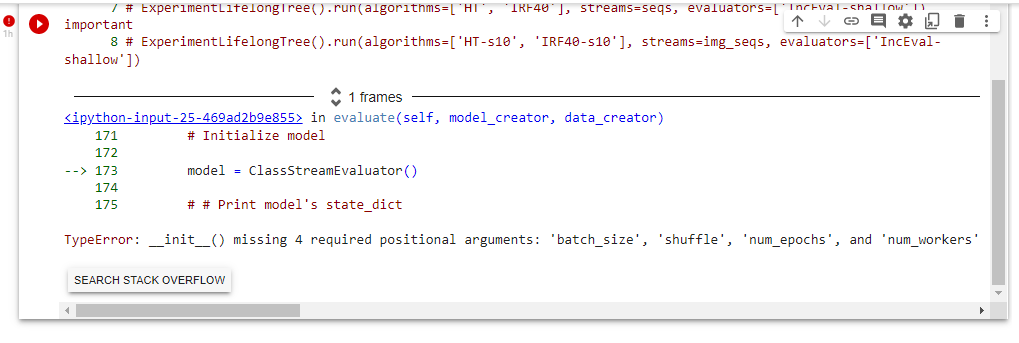

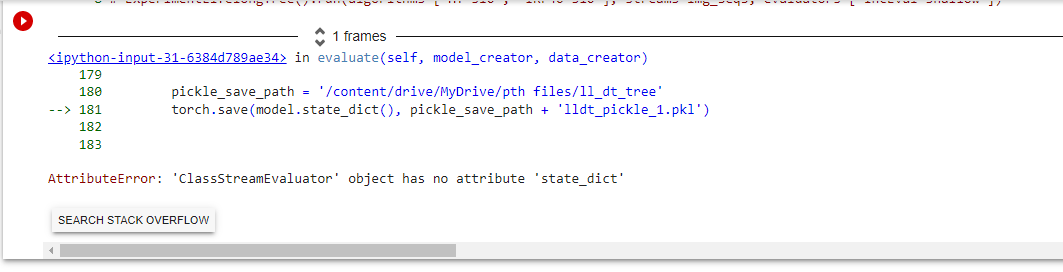